In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import visualkeras
import read_data_tensorflow as read_data
import threading
import tqdm.notebook as tqdm
%matplotlib inline

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

dataset = "fashion_mnist"

#############################################
#load data, fashion MNIST
org_train_images, train_labels, test_images, test_labels = read_data.load_fashion_mnist_dataset()

#load data, MNIST

#org_train_images, train_labels, test_images, test_labels = read_data.load_mnist_dataset()

if dataset == "fashion_mnist":
    train_images = np.expand_dims(org_train_images, 3) #train x
    train_images = train_images.astype(np.float32)
    org_train_images = org_train_images.astype(np.float32)
    test_images = np.expand_dims(test_images, 3)       #test x
    test_images = test_images.astype(np.float32)

    train_labels = train_labels.astype(np.float32)     #train y
    test_labels = test_labels.astype(np.float32)       #test y


#############################################
# cifar10  
if dataset == "cifar10":
    cifar10 = tf.keras.datasets.cifar10
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    colored_train_images = train_images
    #turn to grayscale

    train_images = np.dot(train_images[...,:3], [0.299, 0.587, 0.114]).reshape(50000,32,32,1).astype(np.float32)
    test_images = np.dot(test_images[...,:3], [0.299, 0.587, 0.114]).reshape(10000,32,32,1).astype(np.float32)

    #resize to 28x28
    train_images = tf.image.resize(train_images, [28, 28]).numpy()
    test_images = tf.image.resize(test_images, [28, 28]).numpy()
    print(train_images.shape)

#normalize all data
train_images = train_images /255.0
test_images = test_images   /255.0


In [36]:
#use multiple 1 filter CNN layer to comprise a multi filter CNN layer

#ideas for reducing resolution by factor of 2
#1. use 4x4 filter and stride 2
#2. use 2x2 filter and stride 2
#3. use a flatten layer for computation (?)

#customized activation function
def bell_tanh_activation(x):
    #shapes like a bell
    #when x in 0 to 1, y approaches 1
    #and decreases on both sides and approaches -1
    #use 5+5x tanh
    x1 = 10-5*x
    x2 = 5*x
    return tf.minimum(tf.tanh(x1), tf.tanh(x2))
    
def gaussian_activation(x, tilt_level = 0.85): #last best -- 1.1
    x = tilt_level-tilt_level*x
    return 2*tf.exp(-(x**2)) - 1 #range -1 to 1


def gaussian_activation_01(x, tilt_level = 1):#0.85): #last best -- 1.1
    #x = tilt_level-tilt_level*x
    return tf.exp(-(x**2)) #range 0 to 1


#sigmoid
#1/(1+e^-x)

#======================================================================
# Notes:
# proves that sigmoid is better, for unknown reason
# probably because the gradient is non-zero for all values of x
# In contrast, bell has gradient approaching 0 not only on two ends, but in middle, and hence is harder to train
#======================================================================


class extensible_CNN_layer_multi_module_3D(tf.keras.Model):
    #growth model
    #input: nxnx1
    #output: 1*n
    #filter number can increase
    #last parameter:
    # kernel_size = (4,4), stride = 2, activation = 'gaussian_bell', padding = 'valid', optimizer = 'adam'
    #best: gaussian bell of 1 tilt level, with reg on weight and bias, and 3x3 filter with stride 1
    def __init__(self, kernel_size = (4,4,1), stride = 2, activation = 'sigmoid', padding = 'valid', optimizer = 'adam'): #best -- gaussian_bell, 4x4, stride 2
        super(extensible_CNN_layer_multi_module_3D, self).__init__()
        self.filter_list = []
        self.bias_list = []
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.activation = activation
        self.channels = 1
        self.threshold = 0.5
        if self.activation == "gaussian_bell":
            self.threshold = 0.4 #0.34 final -- 0.4 one layer
        if self.activation == "sigmoid":
            self.threshold = 0.6 #from 0.5 to 0.7
        if self.activation == "relu":
            self.threshold = 0.5
        if self.activation == "gaussian_bell_01":
            self.threshold = 0.7 #last 0.5    
        
        if (activation == 'bell_tanh'):
            self.activation = bell_tanh_activation
        if (activation == 'gaussian_bell'):
            self.activation = gaussian_activation
        if (activation == 'gaussian_bell_01'):
            self.activation = gaussian_activation_01
         

        
        
        self.padding = padding
        self.optimizer = optimizer
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
        else:
            print("\noptimizer not implemented\n")
            return
        
        self.sample_space = {}
        self.filter_list = [] 
        #initialized with 1 filter
        self.aggregated_conv = None
    
    def call(self, input_x):
        #input
        feature_maps = []
        for filter_i in self.filter_list:
            feature_maps.append(filter_i(input_x))
        #feature map of a conv3d layer is: (batch, height, width, depth, channels)
        #ignore batch and channels
        #concatenate the 3D feature maps on the depth axis
        #print("feature_maps shape: ", feature_maps[0].shape)
        
        #print(len(feature_maps), feature_maps[0].shape)
        feature_maps = tf.concat(feature_maps, axis = 3)
        #print("feature_maps shape: ", feature_maps.shape)
        #Final shape -- (batch, height, width, depth, channels), where batch and channels are 1
        return feature_maps
    
    def update_depth(self, new_depth):
        #because with change of previous layer's units, the depth of inputs to this layer changes
        #So update the depth in all filters and sample space of this layer
        #filter_list -- list
        #sample_space -- dict -- key: filter_index, value: sample
        print("original depth: ", self.filter_list[0].get_weights()[0].shape)
        self.kernel_size = (self.kernel_size[0], self.kernel_size[1], new_depth) #update kernel size for new depth
        for filter_index in range(len(self.filter_list)):
            filter_depth = self.filter_list[filter_index].kernel_size[2] #filter depth
            if filter_depth > new_depth:
                #this might be caused by an error
                print("filter depth is larger than new depth\nOnly increase is allowed at this version")
                return
            if filter_depth == new_depth:
                #no need to update
                continue
            
            #create a new filter
            new_filter = tf.keras.layers.Conv3D(filters = 1, kernel_size = self.kernel_size, strides = self.stride, padding = self.padding, activation = self.activation)
            #weights
            new_filter.build(input_shape = (1, self.kernel_size[0], self.kernel_size[1], new_depth, 1))
            new_filter_weights = np.zeros((self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1, 1)).astype('float32') #initialize with 0
            #reduce the newly added weights by 1/sum(newly added weights)
            count_new_weights = self.kernel_size[0]*self.kernel_size[1]*(self.kernel_size[2]-filter_depth)
            reduce_map = np.zeros((self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1, 1)).astype('float32') #initialize with 0
            reduce_map[:, :, :, :, :] -= 1/(new_depth - filter_depth) #reduce by 1/sum(newly added weights) for the newly added weights
            #try to reject the new activation from the input
            #so that after expansion of the input size, the sub-features are considered as new classes
            
            #another way is to not use the reduce map
            #this assumes that the new features are classified as current classes
            
            #a different reduce map will result in different mode. Current mode --> inclusive, may recognize some new patterns as its own class
            #add the old weights
            old_weights = self.filter_list[filter_index].get_weights()[0]
            new_filter_weights[:, :, :filter_depth, 0, 0] += old_weights[:, :, :, 0, 0] #reduce_map[:, :, filter_depth:, 0, 0]
            #add the reduce map
            new_filter_weights[:, :, filter_depth:, 0, 0] += reduce_map[:, :, filter_depth:, 0, 0]
            #add the old weights to the new filter and reduced weights to the new filter
            new_bias = self.filter_list[filter_index].get_weights()[1]
            
            #set the new weights
            new_filter.set_weights([new_filter_weights, new_bias])
            #update the filter
            self.filter_list[filter_index] = new_filter
            
            #update the sample space
            sample_i = self.sample_space[filter_index]
            #add 0s to the end of the sample
            zero_sample = np.zeros((1, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1)).astype('float32')
            zero_sample[0, :, :, :filter_depth, 0] += sample_i[0, :, :, :, 0]
            #update the sample space
            self.sample_space[filter_index] = zero_sample
        #at the end, print a message to show the update is done
        #take the first filter's shape as example
        first_filter_shape = self.filter_list[0].get_weights()[0].shape
        print("update of layer's depth done, new depth: ", first_filter_shape)
        print("new sample space shape: ", self.sample_space[0].shape)
        
        
            
            
            
    
    
    def add_filter(self, x, epochs = 10, refit = False, regularization = True, image_x = None):
        #use autoencoder to generate a new filter which accepts x
        #x: nxnxnx1
        #check if x is fit for filter size
        
        if x.shape != (self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1):
            print("x is not fit for filter size")
            print("x shape: ", x.shape)
            print("expected shape: ", (self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1))
            return
        
        #reshape x to (1, nxnxn, 1)
        x = x.reshape(1, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1) #for 3D conv
        #check if x is equivalent to any existing filter's sample space
        for sample_i in self.sample_space.keys():
            if np.sum(abs(self.sample_space[sample_i] - x)) < 0.2:
                print("x is already in sample space")
                return 0
        
        if image_x is not None:
            print("\nUpdating the sample space")
            #get the feature map for different filters
            for filter_i in range(max(len(self.filter_list) - 5,0), len(self.filter_list)):
                feature_map = self.filter_list[filter_i](image_x)
                #get one of the max value's location
                max_loc_fm = np.unravel_index(np.argmax(feature_map, axis=None), feature_map.shape)#[0]
                #print(max_loc_fm, feature_map.shape, image_x.shape)
                #map back to the image_x
                org_x = max_loc_fm[1]*self.stride
                org_y = max_loc_fm[2]*self.stride
                org_z = max_loc_fm[3]*self.stride
                #find the patch from image_x
                self.sample_space[filter_i] = image_x[:, 
                                                      (org_x):(org_x + self.kernel_size[0]), 
                                                      (org_y):(org_y + self.kernel_size[1]), 
                                                        (org_z):(org_z + self.kernel_size[2]),
                                                      :].reshape(1, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1)
        
        #initialize a new filter with decoder

        new_filter = tf.keras.layers.Conv3D(1, self.kernel_size, 
                                            padding=self.padding, activation=self.activation,strides=self.stride)
        #decoder = tf.keras.layers.Conv3DTranspose(1, self.kernel_size, 
        #                                          padding=self.padding, activation=self.activation)
        
        decoder = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape = (1,1,1,1,1)),
                tf.keras.layers.Dense(np.prod(self.kernel_size), activation = None, use_bias = False),
                tf.keras.layers.Reshape((self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1))
            ])
        
        #set weights of new filter to be the same as x
        print("new filter initialized, id = ", len(self.filter_list))
        
        #initialize new filter
        
        #get the 1 matrix of x
        #TODO: use a better way to get the 1 matrix of x
        #  by giving a suitable threshold -- example, 0.5
        zero_pixel_threshold = 0.1#self.threshold
        
        #matrix_1 = (x > zero_pixel_threshold).astype(np.float64)
        #make the matrix_1, when multiplied by x, the output is 1
        #assigning top n to 1, and rest to -1, to make the output of the dot product to be 1
        #find the threshold, where the values below and above sum to same value
        #because the range of x is 0 to 1, the sum of the values below and above the threshold is 0.5
        random_filter = np.random.rand(self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1)/5
        threshold_same_sum = 0

        
        for i in range(100):
            threshold = i/100
            x_above = x[x > threshold]
            x_below = x[x <= threshold]
            #if (np.sum(x_above) - np.sum(x_below)) <= 1:
            #    threshold_same_sum = threshold
            #    break
            x_above_square = np.square(x_above)
            x_below_square = np.square(x_below)
            if (np.sum(x_above_square) - np.sum(x_below_square)) <= 1:
                threshold_same_sum = threshold
                break
            if i == 99:
                threshold_same_sum = np.max(x) - 0.01
        print("threshold_same_sum: ", threshold_same_sum)
        #x_above = x[x > threshold_same_sum] + np.zeros(x.shape)
        #x_below = x[x <= threshold_same_sum] + np.zeros(x.shape)
        matrix_1 = np.zeros(x.shape)
        matrix_1[x > threshold_same_sum] = 1
        #matrix_1[x <= threshold_same_sum] = -1
        if self.activation == gaussian_activation_01 and self.kernel_size[2] > 3:
            matrix_1[x <= threshold_same_sum] = 0
        else:
            matrix_1[x <= threshold_same_sum] = -1
        
        #mode 2
        if self.activation == gaussian_activation_01 and self.kernel_size[2] > 3:
            matrix_1 = np.multiply(matrix_1, x)
            

        #mode 1    
        elif self.activation == gaussian_activation_01 and self.kernel_size[2] <= 3:
            matrix_1_positive_sum = abs(np.sum(matrix_1[x > threshold_same_sum]))
            matrix_1_negative_sum = abs(np.sum(matrix_1[x <= threshold_same_sum]))
            matrix_1[x <= threshold_same_sum] = matrix_1[x <= threshold_same_sum]/(matrix_1_negative_sum / matrix_1_positive_sum)
        
        else:
            '''
            matrix_1[x > threshold_same_sum] = 1
            sum_1 = np.sum(matrix_1[x > threshold_same_sum])/2
            matrix_1[x > threshold_same_sum] = matrix_1[x > threshold_same_sum]/sum_1
            
            matrix_1[x <= threshold_same_sum] = -1
            sum_0 = abs(np.sum(matrix_1[x <= threshold_same_sum]))
            matrix_1[x <= threshold_same_sum] = matrix_1[x <= threshold_same_sum]/sum_0
            '''
            
            #cast x into the range of -1 to 1, with same variance
            matrix_1 = (x - np.mean(x))/np.std(x)
            
            matrix_1 = matrix_1/(np.sum(np.multiply(matrix_1, x)))
            #matrix_1 = np.multiply(matrix_1, x)
            #matrix_1 = matrix_1/np.max(matrix_1)
            print("result 0", np.sum(np.multiply(matrix_1, x)))
        


        
        bias = np.array([-1]) #0
        
        if (np.max(x) > zero_pixel_threshold) and np.sum(x) != np.prod(x.shape): #if sum equas to prod, then all pixels are 1, which is used for initialization
            #characterization =(x/np.max(x))
            #equals to the 1 matrix of x
            #random_filter = np.random.rand(3,3,1)/5
            
            #avoid a random_filter value on pixel <= 0
            #multiply by dot product of matrix_1 and random_filter
            random_filter = np.multiply(matrix_1, random_filter)
            
            #devide by 5 so that the maximum output is 0.2*16 - 1 = 2.2
            #characterization = characterization/5  #/np.average(characterization)
            
            #or divide by the size of the filter, setting bias to 0, so the output is 1
            
            #bias = np.array([-np.sum(matrix_1)])
            if self.activation == gaussian_activation_01:
                bias = np.array([-(np.sum(np.multiply(matrix_1, x)))])
            else:
                print("sum of matrix_1 = ", np.sum(matrix_1))
                #print(matrix_1)
                bias = np.array([0])
            '''          
            characterization = (matrix_1)# + x) - random_filter
            matrix_n1 = matrix_1 - 1 #if is 0, then -1
            #matrix_n1 *= (np.sum(characterization))
            characterization = characterization + matrix_n1
            
            characterization -= random_filter
            characterization -= np.mean(characterization)
            '''
            
            #V3
            characterization = (matrix_1)# - zero_pixel_threshold
            #print("characterization shape = ", characterization.shape, "bias = ", float(bias), characterization)
            #characterization -= random_filter
            #print("characterization = ", characterization)
            print("char sum:", np.sum(characterization))
            #characterization = characterization/np.sum(characterization) #so when product with x, the output is 1
            
            
        elif np.max(x) <= zero_pixel_threshold:
            bias = np.array([1])
            characterization = x - 2*(bias)    #/(np.max(x)+0.01)
            #print(characterization)
        elif np.sum(x) == np.prod(x.shape):
            print("all 1")
            
            characterization = x/np.sum(x) #
            bias = np.array([-np.sum(characterization)/2])
            
        #print("characterization = ", characterization, "matrix_1 = ", matrix_1)
        #characterization = np.asarray(characterization - 1 + matrix_1).reshape(1,self.kernel_size[0],self.kernel_size[1],1).astype(np.float64)
        characterization = np.asarray(characterization).reshape(1,self.kernel_size[0],self.kernel_size[1], self.kernel_size[2], 1).astype(np.float64)
        
        #normalize
        #characterization = characterization/np.max(characterization)
        new_filter.build(input_shape = (None,self.kernel_size[0],self.kernel_size[1],self.kernel_size[2],1))
        weight = characterization.reshape(self.kernel_size[0],self.kernel_size[1],self.kernel_size[2],1,1)
        new_filter.set_weights([weight, bias])
        decoder.build(input_shape = (None,1,1,1,1))
        weight2 = x.reshape(self.kernel_size[0],self.kernel_size[1],self.kernel_size[2],1,1)/(0.7)
        weight2 = weight2.reshape(1,np.prod(weight2.shape))
        '''
        print("weight 2")
        print(weight2.reshape(4,4))'''
        #decoder.set_weights([weight, bias])
        decoder.set_weights([weight2])#, np.array([0]*np.prod(weight2.shape))])
        #the weight of this filter is characterized by x
        '''
        print("simulating")
        print(new_filter(x))
        print(decoder(new_filter(x)).numpy().shape)
        print(tf.reduce_sum(tf.square(decoder(new_filter(x)) - x)))
        print("reconstruction, decoder out and x")
        print(decoder(new_filter(x)).numpy().reshape(4,4), "\n",x.reshape(4,4))
        print("weights")
        print(weight2.reshape(4,4))'''
        #train the new filter
        #new filter must reject all other x in the sample space
        self.filter_list.append(new_filter)
        
        def calc_reg(weight, bias):
            reg = 0
            #reg = tf.reduce_sum((tf.square(weight)))# + tf.reduce_sum(tf.square(bias))
            #reg = tf.reduce_sum((weight))
            #reg += tf.reduce_sum(bias)
            #reg += tf.reduce_sum(tf.square(bias))
            #reg = tf.square(reg)
            
            return reg
            
        #==============================================
        #sub-functions that can be reused in this function
        def call_autoencoder(x):
            y = new_filter(x)
            y = decoder(y)
            #because decoder has activation, so y is in range [0,1]
            #hence magnify y by max in x
            y = y * np.max(x)
            return y
        def combined_fit_v3(target, negative_samples):
            loss = 0
            
            #the negative samples in this version is a list of all negative samples
            with tf.GradientTape(persistent=True) as tape:
                y = call_autoencoder(target)
                #use sum of square error as loss function
                loss = tf.reduce_sum(tf.square(y - target))
                #expect y to be close to 0
                #fetch the loss of each negative sample
                if self.activation == gaussian_activation_01:
                    loss += (tf.reduce_sum(tf.square(new_filter(target) - 1)))
                else:
                    loss += (tf.reduce_sum(tf.square(new_filter(target) - 0.75))) #0.75 is the p of sigmoid when x = 1
                if self.activation != gaussian_activation_01:
                    
                    #for neg_sample in negative_samples:
                    #    z = new_filter(neg_sample)
                    #    target_z = 0#-1, make the negative samples always exist in loss back propagation instead of ignoring it during training
                    #    if self.activation == gaussian_activation_01:
                    #        target_z = -1
                    #    loss += tf.reduce_sum(tf.square(z - target_z)) #the averaged loss
                    
                    if len(negative_samples) > 0:
                        target_vec = np.zeros(len(negative_samples))
                        if self.activation == gaussian_activation_01:
                            target_vec = -np.ones(len(negative_samples))
                        pred_vec = new_filter(np.array(negative_samples))
                        #if pred_vec > threshold, then it is a negative sample
                        #only take the negative samples' loss
                        threshold = self.threshold
                        bool_vec = tf.math.greater(pred_vec, threshold)
                        pred_vec = tf.where(bool_vec, pred_vec, tf.zeros_like(pred_vec))
                        #print("pred_vec = ", pred_vec)
                        loss += tf.reduce_sum(tf.square(pred_vec - target_vec))
                    
                    #if the depth is greater than 3, then it is after another layer. Use regularization
                    if self.kernel_size[2] > 3:
                        #regularization -- make the weights close to 0
                        loss += np.sum(np.square(new_filter.weights[0]))



                else:
                    #for gaussian activation, the negative samples are not needed
                    #but need to make the bias close to 0, and have larger variance on the weights
                    loss += np.sum(np.square(new_filter.weights[1]))
                    var_w = np.var(new_filter.weights[0])
                    loss -= var_w
                    
                    #take last 10 negative samples
                    
                    neg_sample_list = []
                    if len(negative_samples) > 0 and self.kernel_size[2] <= 3:
                        for i in range( len(negative_samples)):
                            neg_sample_list.append(negative_samples[-i])
                        neg_sample_list = np.array(neg_sample_list)
                        neg_pred = new_filter(neg_sample_list)
                        loss += np.sum(np.square(neg_pred))/len(negative_samples)
                    

                
                    
            grad_filter = tape.gradient(loss, new_filter.trainable_variables)
            #grad_decoder = tape.gradient(loss, decoder.trainable_variables)
            self.optimizer.apply_gradients(zip(grad_filter, new_filter.trainable_variables))
            #last best not update decoder
            #self.optimizer.apply_gradients(zip(grad_decoder, decoder.trainable_variables))
            #clear tape
            tf.keras.backend.clear_session()
            return loss
        
        #
        progress_bar = tf.keras.utils.Progbar(epochs)
        

        '''
        print("\ncombined training")
        for epoch in (range(epochs)):
            loss = 0
            for i in range(len(self.filter_list) - 1):
                loss = combined_fit(x, self.sample_space[i])
            progress_bar.update(epoch, values=[("loss", loss)])
        ''' 
        
        print("\ncombined training v3")
        neg_samples = []
        for i in range(len(self.filter_list) - 1):
            neg_samples.append(self.sample_space[i])
        for epoch in (range(epochs)):
            loss = 0
            loss = combined_fit_v3(x, neg_samples)
            progress_bar.update(epoch, values=[("loss", loss)])
        
            
        
        self.sample_space[len(self.filter_list) - 1] = x #.reshape(1, self.kernel_size[0], self.kernel_size[1], 1) #add to sample space

        
        self.filter_list[len(self.filter_list) - 1] = new_filter #replace the filter
        
        


        if refit:
            #fit all the filters
            self.refit_all(epochs = epochs)
        
        return new_filter
    
    
    def refit_all(self, epochs = 100, image_x = None):
        #refit all the filters with their own sample (1) and other filters' samples (-1)
        #update the sample space
                
        def refit_filter(idx, epochs):
            print("\nrefitting filter ", idx)
            progress_bar = tf.keras.utils.Progbar(epochs)
            for epoch in range(epochs):
                filter_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
                loss = 0
                with tf.GradientTape(persistent=True) as tape:
                    
                    #fit the filter
                    for i in range(len(self.filter_list)):
                        if (i == idx):
                            loss += tf.reduce_sum(tf.square(self.filter_list[i](self.sample_space[i]) - 1))
                        else:
                            loss += tf.reduce_sum(tf.square(self.filter_list[i](self.sample_space[i]) - -1))
                grad_filter = tape.gradient(loss, self.filter_list[idx].trainable_variables)
                filter_optimizer.apply_gradients(zip(grad_filter, self.filter_list[idx].trainable_variables))
                progress_bar.update(epoch, values=[("loss", loss)])
            #clear tape
            
            tf.keras.backend.clear_session()
            
        
        for i in range(max(int(len(self.filter_list)/2)-1,0), len(self.filter_list)):
            refit_filter(i, epochs)

    
    
    
    def get_index_map(self, x):
        feature_maps = self.call(x)
        return np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    
    
    def call_seperated_fm(self, x):
        feature_maps = []
        for i in range(len(self.filter_list)):
            feature_maps.append(self.filter_list[i](x))
        return feature_maps
            
    def get_aggregated_conv(self):
        #return the aggregated convolutional layer by building a conv layer with the weights in the filter list
        #to set layer weights
        #kernel_size[0], kernel_size[1], kernel_size[2], channel, len(self.filter_list)
        weights = np.zeros((self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1, len(self.filter_list)))
        biases = np.zeros((len(self.filter_list)))
        for i in tqdm.tqdm(range(len(self.filter_list))):
            weight_i = self.filter_list[i].get_weights()[0].reshape(self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1, 1)
            bias_i = self.filter_list[i].get_weights()[1].reshape(1)
            weights[:,:,:,0,i] = weight_i[:,:,:,0,0]
            biases[i] = bias_i[0]
        new_conv = tf.keras.layers.Conv3D(len(self.filter_list), self.kernel_size, strides = self.stride, padding = "valid", activation =self.activation)
        new_conv.build((None, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2], 1))
        self.aggregated_conv = new_conv
        return new_conv
    
    
        
            
#new_filter = customized_CNN_kernel(4, 2, 'relu')

def show_indedx_act_map_2D(model, img):
    threshold = model.threshold
    
    #show the index map and activation map
    
    feature_maps = model.call(img.reshape(1, img.shape[0], img.shape[1], 1))
    index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    #print("!")
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(index_map, cmap = "gist_ncar")
    ax.set_title("index map")
    
    #print("index map shape", index_map.shape)
    activated_points = np.zeros(np.shape(index_map))
    mapping = np.max(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    activated_points[mapping > 0.5] = 1
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(mapping, cmap = "gray")
    print("min and max", np.min(mapping), np.max(mapping))
    #plt.set_title("activated points")
    
    fig.show()
    plt.show()
    
def show_all_index_maps_2D(model, data_0_9):
    #show the heatmap of 10 images
    #show 20 images
    figure = plt.figure(figsize=(20, 20))


    #show the heatmap of 10 images and 10 original images
    #5 images one row

    for i in range(len(images_x_0_9)):
        feature_maps = tf.convert_to_tensor(my_model.call(images_x_0_9[i]).numpy().astype('float64'))
        plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+1 + (i // 5) * 5)
        plt.imshow(images_x_0_9[i].reshape(28,28), cmap='gray')
        plt.title("label "+ str(i))
        plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+6 + (i // 5) * 5)
        index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
        plt.imshow(index_map, cmap='gist_ncar')

    plt.show()

def show_all_index_maps_3D(model, data_0_9):
    figure = plt.figure(figsize=(20, 20))
    
    for i in range(len(data_0_9)):
        
        feature_maps = tf.convert_to_tensor(model.call(data_0_9[i]).numpy().astype('float64'))
        plt.subplot((len(data_0_9) * 2) // 5, 5, i+1 + (i // 5) * 5)
        plt.imshow(images_x_0_9[i].reshape(28,28), cmap='gray')
        plt.title("label "+ str(i))
        plt.subplot((len(data_0_9) * 2) // 5, 5, i+6 + (i // 5) * 5)
        index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-2])
        plt.imshow(index_map, cmap='gist_ncar')
    plt.show()
    

        

            

In [37]:
images_x_0_9 = []
for i in range(10):
    images_x_0_9.append(train_images[np.where(train_labels == i)[0][0]])
    
fm_0_9 = []
#give the feature maps processed by first layer



In [38]:

def generate_filter(image, model, image_shape, fm_0_9):
    if image_shape[2] > model.kernel_size[2]:
        model.update_depth(image_shape[2])
    print("image shape", image_shape)
    kernel_size = model.kernel_size
    stride = model.stride
    #image_shape ---> (x, y, z)
    image = image.reshape(1, image_shape[0], image_shape[1], image_shape[2], 1)
    feature_map_size_xy = (image_shape[0] - kernel_size[0]) // stride + 1
    feature_map_size_z = (image_shape[2] - kernel_size[2]) // stride + 1
    feature_map_size = (feature_map_size_xy, feature_map_size_xy, feature_map_size_z)

    if len(model.filter_list) == 0:
        null_input = np.zeros((kernel_size[0], kernel_size[1], kernel_size[2], 1))
        new_filter = model.add_filter(null_input, epochs = 100)
        
        #one_input = np.zeros((kernel_size[0], kernel_size[1], kernel_size[2], 1))+0.1
        ##make the center point to 1
        #one_input[kernel_size[0]//2, kernel_size[1]//2, kernel_size[2]//2, 0] = 1
        #new_filter = model.add_filter(one_input, epochs = 100)
        #one_input = np.ones((kernel_size[0], kernel_size[1], kernel_size[2], 1))#*(1/np.prod(kernel_size)) #0.7 is around the 1 of the sigmoid function
        #new_filter = model.add_filter(one_input, epochs = 100)
        
        if new_filter is None:
            print("ERROR null filter")
    
    feature_maps = model.call(image.reshape(1, image_shape[0], image_shape[1], image_shape[2], 1))
    #feature map size --  1, x, y, z, 1
    #separate to multiple feature maps corresponding back to different filters
    feature_maps_of_filters = []
    
    for i in range(len(model.filter_list)):
        depth_start = i * feature_map_size[2]
        depth_end = (i+1) * feature_map_size[2]
        feature_maps_of_filters.append(feature_maps[:, :, :, depth_start:depth_end, :])
    #add together and divide by the number of filters
    
    #find the maximum values within the feature maps
    #print(model)
    max_values_on_maps = np.zeros(feature_map_size)
    for fm in feature_maps_of_filters:
        fm = (fm>model.threshold).numpy().astype(np.float32)
        max_values_on_maps += fm.reshape(feature_map_size)
    
    
    inactive_points = np.where(max_values_on_maps == 0)
    inactive_ratio_0 = len(inactive_points[0])/np.prod(np.shape(max_values_on_maps))
    #check how many points are inactive
    print ("inactive ratio ", inactive_ratio_0)
    
    if len(inactive_points[0]) == 0:
        return model, inactive_ratio_0
    
    point = np.random.choice(len(inactive_points[0]))
    selected = point# % 10 #first 10 points are usually the edge points
    
    
    x = inactive_points[0][selected]
    y = inactive_points[1][selected]
    z = inactive_points[2][selected]
    
    print("selected point", x, y, z)
    
    #get the patch of the image that corresponds to the selected point
    org_x_start = x * stride
    org_y_start = y * stride
    org_z_start = z * stride
    org_x_end = org_x_start + kernel_size[0]
    org_y_end = org_y_start + kernel_size[1]
    org_z_end = org_z_start + kernel_size[2]
    
    patch = image[:, org_x_start:org_x_end, org_y_start:org_y_end, org_z_start:org_z_end, :]
    patch = patch.reshape(kernel_size[0], kernel_size[1], kernel_size[2], 1)
    new_filter = model.add_filter(patch, epochs = 100, image_x = image)
    
    separated_new_fms = model.call_seperated_fm(image)
    max_map = np.zeros(separated_new_fms[0].shape)
    for fm in separated_new_fms:
        fm = (fm>model.threshold).numpy().astype(np.float32)
        max_map += fm.reshape(separated_new_fms[0].shape)
        
    inactive_points_check = np.where(max_map == 0)
    inactive_ratio_1 = len(inactive_points_check[0])/np.prod(np.shape(max_map))
    print("inactive ratio after adding filter", inactive_ratio_1)
    
    if (inactive_ratio_1 >= inactive_ratio_0 and new_filter != 0):
        #remove the filter
        print("removing filter")
        #print(model.filter_list[-1].get_weights()[0])
        last_idx = len(model.filter_list) - 1
        model.filter_list.pop()
        model.sample_space.pop(last_idx)
    
    
    show_all_index_maps_3D(model, data_0_9=fm_0_9)
    return model, inactive_ratio_1
    

#np.random.seed(1)
def generate_model(img_x, model = None):
    image_x = img_x.reshape(1, img_x.shape[0], img_x.shape[1], 1)
    last_selected = [-1, -1]

    
    my_model = model
    if model == None:
        my_model = extensible_CNN_layer_multi_module_3D()
    
    filter_size = my_model.kernel_size
    stride = my_model.stride
    
    threshold = my_model.threshold
    

    print("activation and threshold")
    print(my_model.activation, threshold)
    for i in range(20): #generate a series of filters
        generate_filter(image_x, my_model, image_x.shape[1:])

    #print(my_model.activation, len(my_model.filter_list))
    return my_model
    

def get_inactive_ratio(model, image):
    
    fm_i = model.call_seperated_fm(image)
    max_map = np.zeros(fm_i[0].shape)
    for fm in fm_i:
        fm = (fm>model.threshold).numpy().astype(np.float32)
        max_map += fm.reshape(fm_i[0].shape)
    inactive_ratio = len(np.where(max_map == 0)[0])/np.prod(np.shape(max_map))
    return inactive_ratio
        
    
def get_inactive_ratio_list(model, images):
    inactive_ratios = []
    for img in images:
        inactive_ratios.append(get_inactive_ratio(model, img))
    return inactive_ratios

def generate_model_on_images(images, model, images_0_9, inactive_ratio_threshold = 0.1, n = 3):
    #initialize by generating 2 filters on the first image
    if model == None:
        model = extensible_CNN_layer_multi_module_3D()
    
    #model = generate_filter(images[0], model, threshold = model.threshold)
    
    #loop through the images, generate filters
    
    inactive_ratios = [0 for i in range(len(images))]
    '''
    for i in range(len(images)):
        print("\nimage ", i)
        model, ratio = generate_filter(images[i], model, images[i].shape[1:], fm_0_9=images_0_9)
        inactive_ratios[i] = ratio
    '''
    
    #If the model has no filter, first round, generate 1 filter on randomly selected n images
    if len(model.filter_list) == 0:
        for i in range(n):
            image_idx = np.random.randint(len(images))
            print("\nimage ", image_idx)
            model, ratio = generate_filter(images[image_idx], model, images[image_idx].shape[1:], fm_0_9=images_0_9)
            inactive_ratios[image_idx] = ratio
        
    #then generate 1 filter on the image with the highest inactive ratio
    
    inactive_ratios = get_inactive_ratio_list(model, images)
    
    mean_inactive_ratio = np.mean(inactive_ratios)
    max_inactive_ratio = np.max(inactive_ratios)
    print("inactive ratios mean", mean_inactive_ratio, inactive_ratios)
    
    if max_inactive_ratio < inactive_ratio_threshold:
        return model

    #get top n images with highest inactive ratio
    top_n_inactive_ratio_idx = np.argsort(inactive_ratios)[-n:]
    for i in top_n_inactive_ratio_idx:
        print("\nimage ", i)
        model, ratio = generate_filter(images[i], model, images[i].shape[1:], fm_0_9=images_0_9)
    
    
    print(model.activation, len(model.filter_list))
    return model
        

def examin_aggregated_conv(images_x_0_9, layer):
    figure = plt.figure(figsize=(10, 10))
    
    fms = layer(np.array(images_x_0_9).reshape(10, image_size, image_size, 1, 1))
    for i in range(10):
        #print(fms[i].shape)
        fm_i = fms[i].numpy().reshape(fms[i].shape[0], fms[i].shape[1], fms.shape[-1])
        index_map = np.argmax(fm_i, axis = 2)
        #print(fm_i.shape, index_map.shape)
        ax_i = figure.add_subplot(2, 5, i+1)
        ax_i.imshow(index_map, cmap = "gist_ncar")
    #show_all_index_maps_3D(data_0_9=images_y_0_9, model=my_model)
    
    

In [39]:
#get the images 0 - 9
images_x_0_9 = []
images_y_0_9 = []
image_size = len(train_images[0])
n_shot = 1
for label_idx in range(10):
    for i in range(n_shot):
        image_label_i = np.where(train_labels == label_idx)[0]
        image_x_i = train_images[image_label_i][i].reshape(1,image_size,image_size,1, 1).astype('float64')
        image_y_i = label_idx
        one_hot_y_i = tf.one_hot(image_y_i, 10).numpy().reshape(1,10)
        #train_one_shot(image_x_i, one_hot_y_i)
        images_x_0_9.append(image_x_i)
        images_y_0_9.append(one_hot_y_i)
    
print(len(images_x_0_9))

10


epoch 0

image  0
image shape (28, 28, 1, 1)
new filter initialized, id =  0
threshold_same_sum:  0.0
result 0 nan

combined training v3
 14/100 [===>..........................] - ETA: 0s - loss: 8.2180e-0

C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in true_divide


 99/100 [============================>.] - ETA: 0s - loss: 1.4693e-05inactive ratio  0.7751479289940828
selected point 5 9 0

Updating the sample space
new filter initialized, id =  1
threshold_same_sum:  0.83
result 0 1.0000000000000004
sum of matrix_1 =  1.1102230246251565e-16
char sum: 1.1102230246251565e-16

combined training v3
 98/100 [============================>.] - ETA: 0s - loss: 0.1347inactive ratio after adding filter 0.5976331360946746


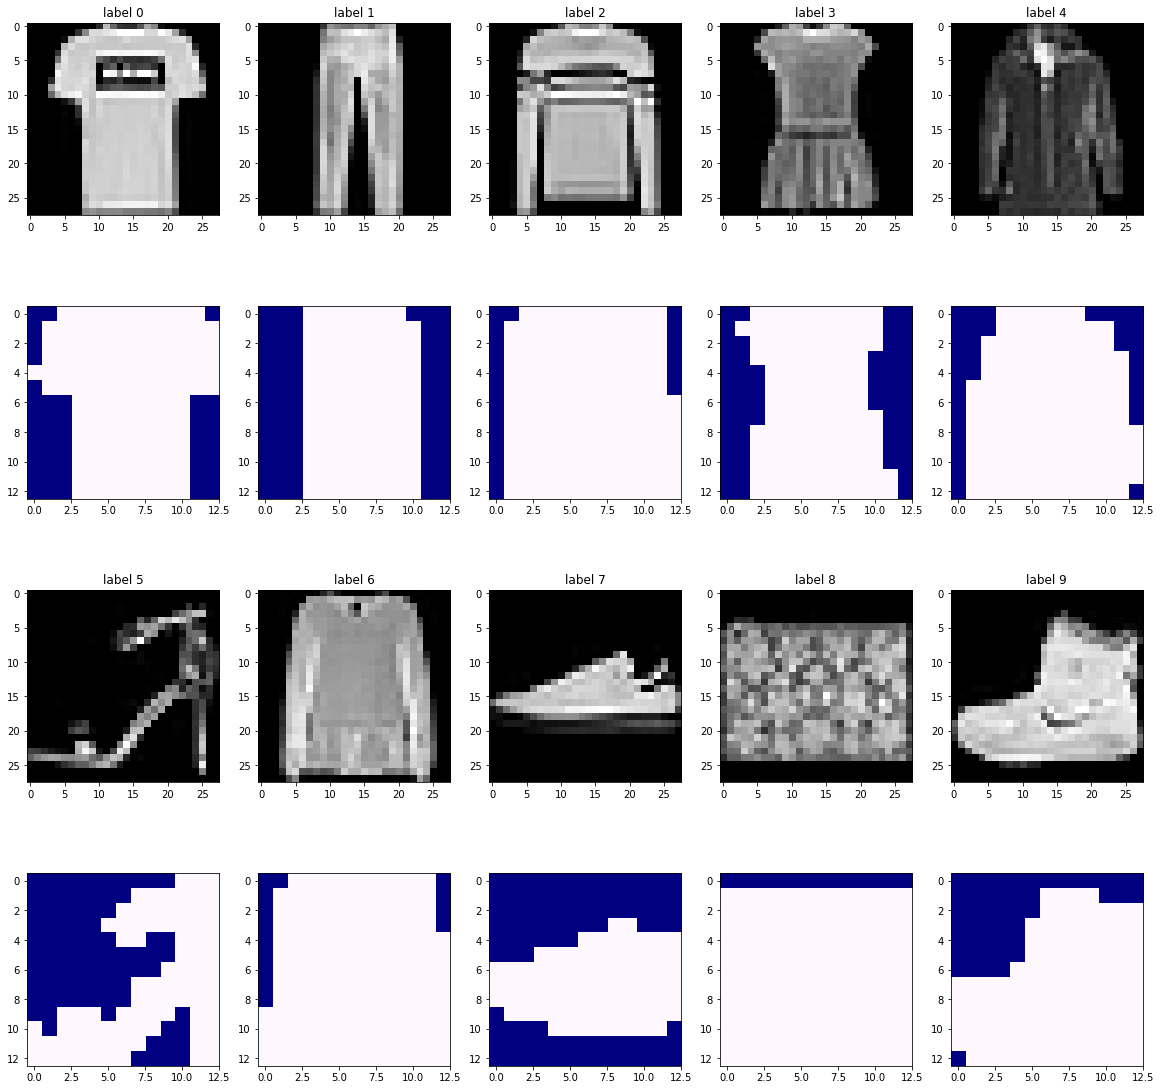


image  0
image shape (28, 28, 1, 1)
inactive ratio  0.5976331360946746
selected point 4 4 0

Updating the sample space
new filter initialized, id =  2
threshold_same_sum:  0.83
result 0 1.0
sum of matrix_1 =  0.0
char sum: 0.0

combined training v3
 97/100 [============================>.] - ETA: 0s - loss: 0.1442inactive ratio after adding filter 0.5621301775147929


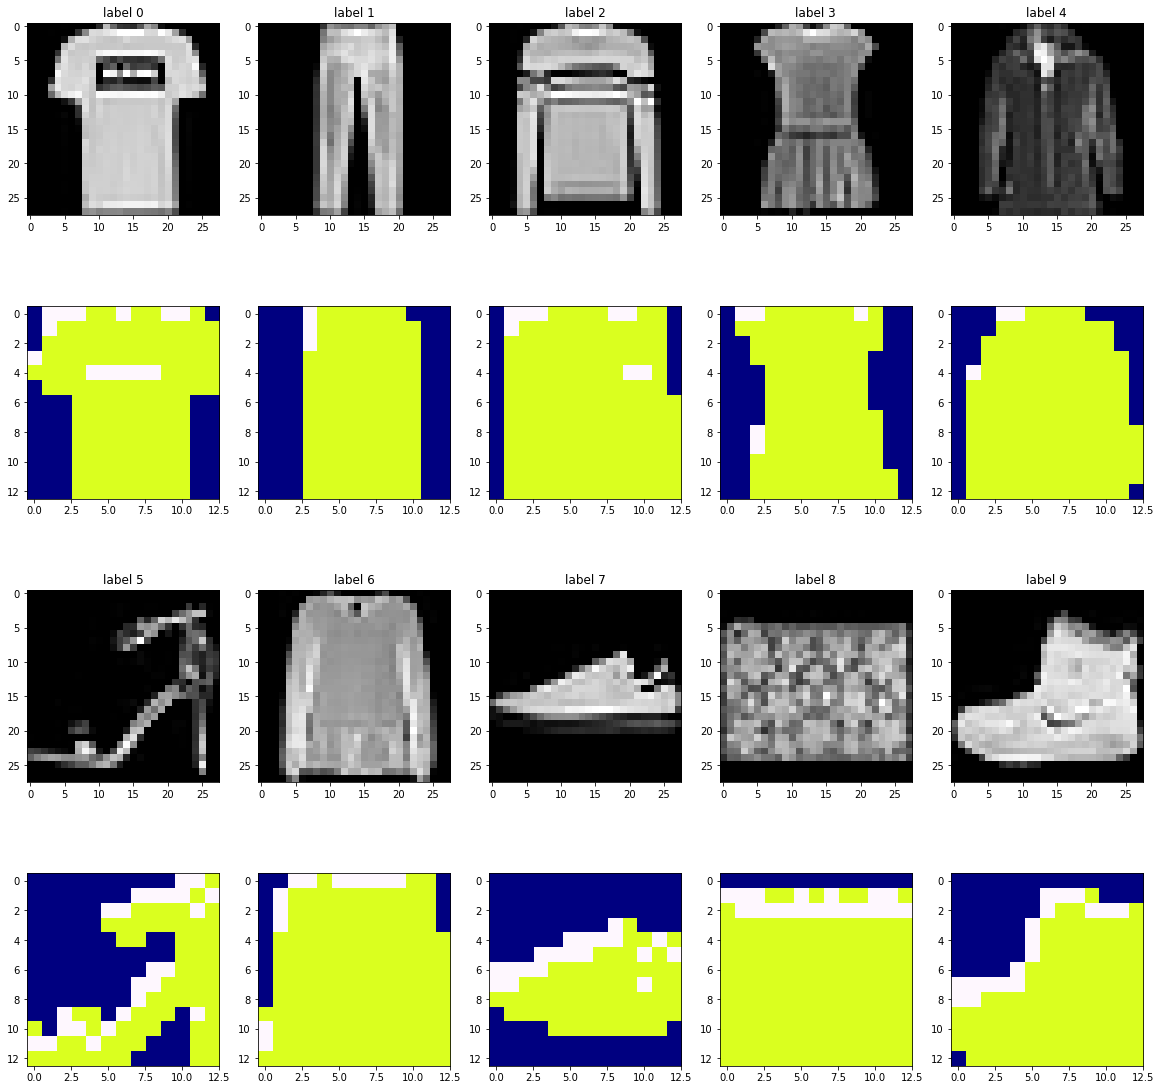


image  0
image shape (28, 28, 1, 1)
inactive ratio  0.5621301775147929
selected point 6 8 0

Updating the sample space
new filter initialized, id =  3
threshold_same_sum:  0.81
result 0 1.0000000000000009
sum of matrix_1 =  -1.7763568394002505e-15
char sum: -1.7763568394002505e-15

combined training v3
 96/100 [===========================>..] - ETA: 0s - loss: 0.3821- ETA: 1s - loss: 2 - ETA: 0s - linactive ratio after adding filter 0.1893491124260355


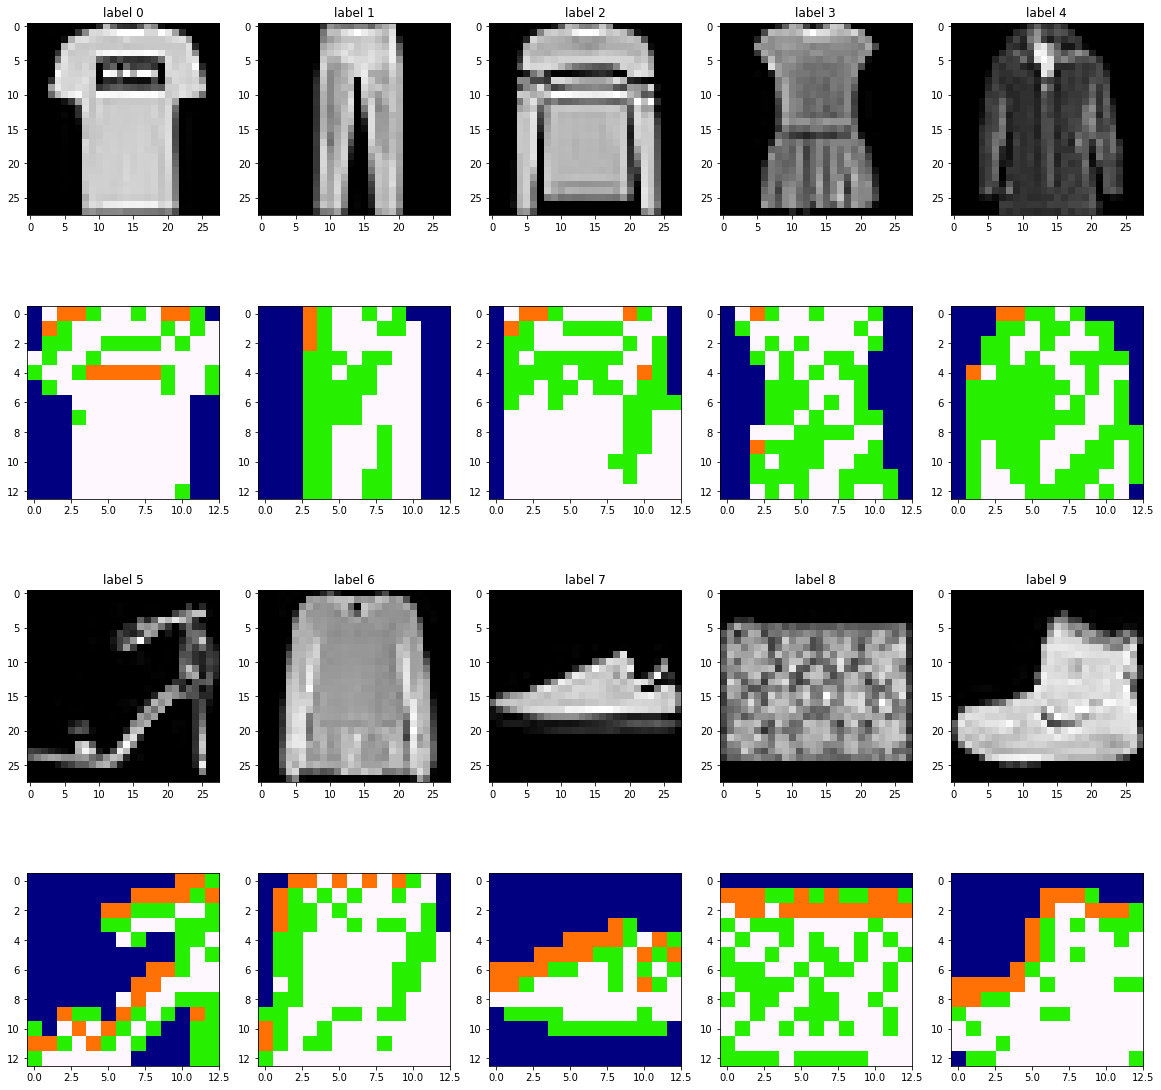

inactive ratios mean 0.1893491124260355 [0.1893491124260355]

image  0
image shape (28, 28, 1, 1)
inactive ratio  0.1893491124260355
selected point 4 3 0

Updating the sample space
new filter initialized, id =  4
threshold_same_sum:  0.84
result 0 1.0000000000000002
sum of matrix_1 =  0.0
char sum: 0.0

combined training v3
 97/100 [============================>.] - ETA: 0s - loss: 0.4264inactive ratio after adding filter 0.11834319526627218


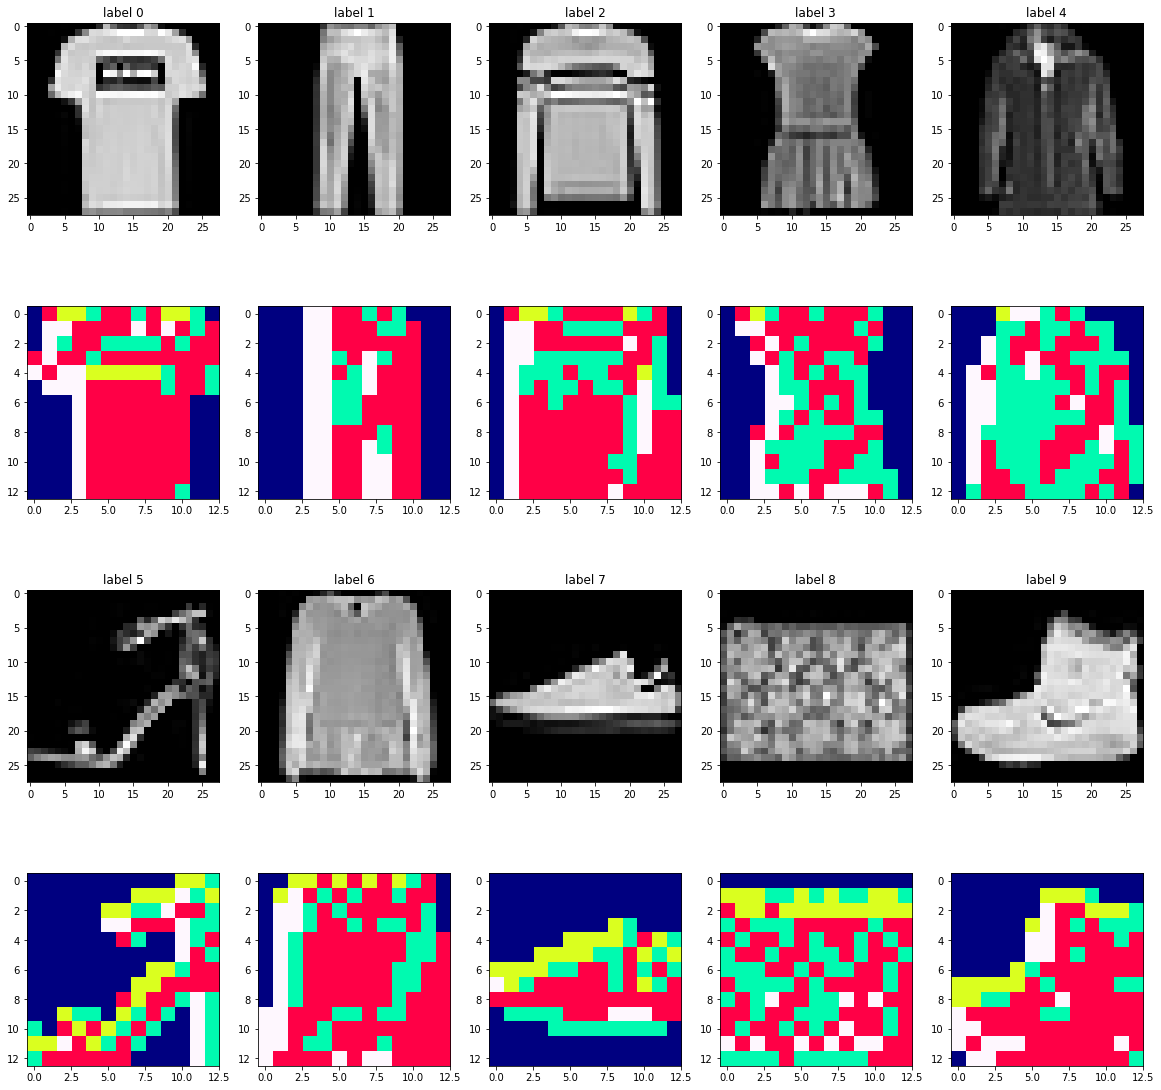

sigmoid 5
epoch 1
inactive ratios mean 0.11834319526627218 [0.11834319526627218]

image  0
image shape (28, 28, 1, 1)
inactive ratio  0.11834319526627218
selected point 11 4 0

Updating the sample space
new filter initialized, id =  5
threshold_same_sum:  0.82
result 0 0.9999999999999996
sum of matrix_1 =  -1.7763568394002505e-15
char sum: -1.7763568394002505e-15

combined training v3
 99/100 [============================>.] - ETA: 0s - loss: 2.3434inactive ratio after adding filter 0.023668639053254437


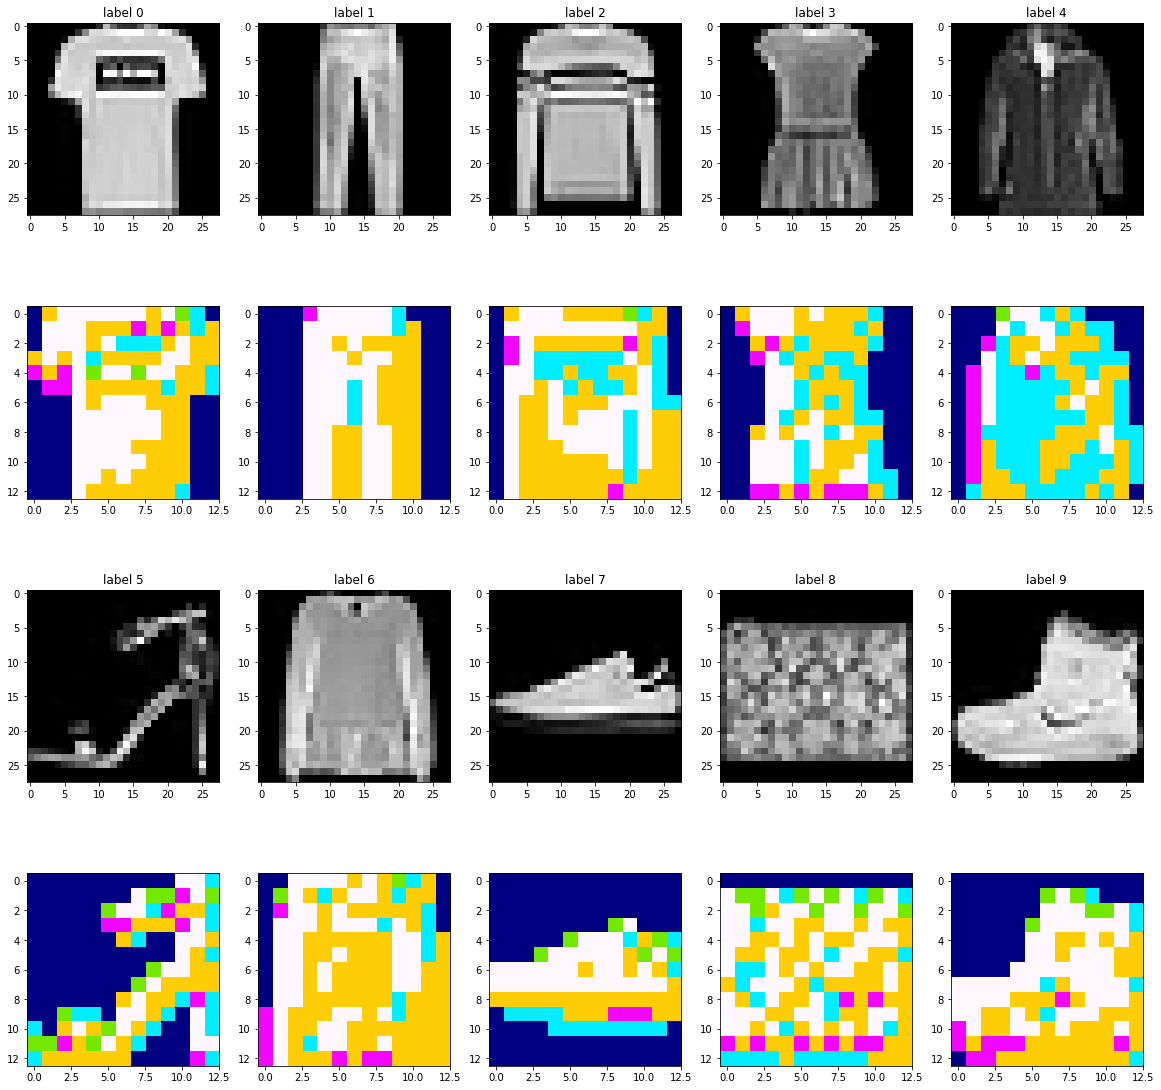

sigmoid 6
epoch 2
inactive ratios mean 0.023668639053254437 [0.023668639053254437]

image  0
image shape (28, 28, 1, 1)
inactive ratio  0.023668639053254437
selected point 6 2 0

Updating the sample space
new filter initialized, id =  6
threshold_same_sum:  0.0
result 0 1.0
sum of matrix_1 =  2.220446049250313e-16
char sum: 2.220446049250313e-16

combined training v3
 97/100 [============================>.] - ETA: 0s - loss: 0.3852inactive ratio after adding filter 0.011834319526627219


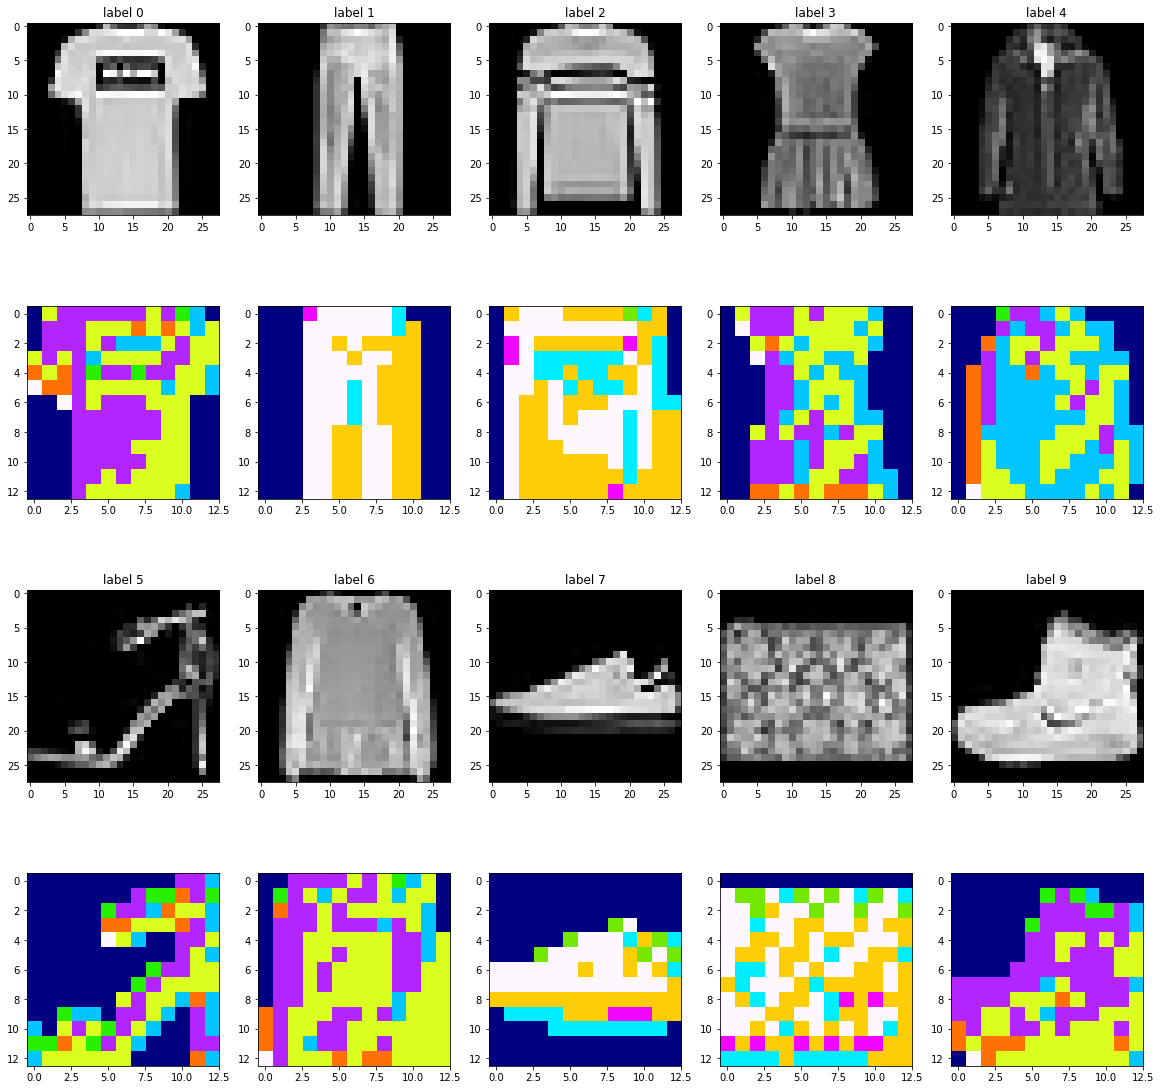

sigmoid 7
epoch 3
inactive ratios mean 0.011834319526627219 [0.011834319526627219]

image  0
image shape (28, 28, 1, 1)
inactive ratio  0.011834319526627219
selected point 2 7 0

Updating the sample space
new filter initialized, id =  7
threshold_same_sum:  0.98
result 0 1.0
sum of matrix_1 =  -1.1102230246251565e-16
char sum: -1.1102230246251565e-16

combined training v3
 98/100 [============================>.] - ETA: 0s - loss: 0.5291inactive ratio after adding filter 0.005917159763313609


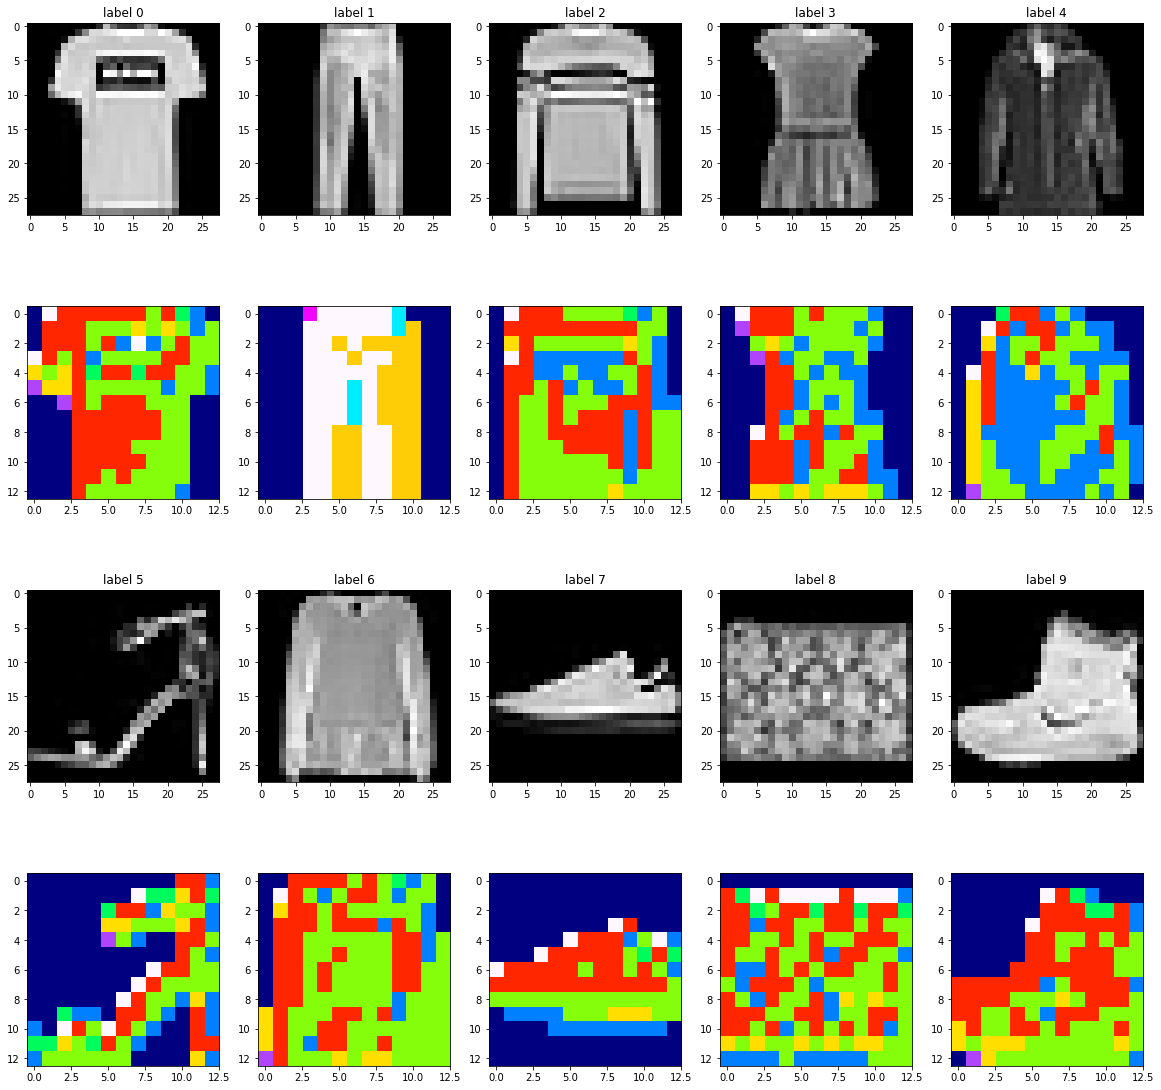

sigmoid 8
epoch 4
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 5
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 6
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 7
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 8
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 9
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 10
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 11
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 12
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 13
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 14
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 15
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 16
inactive ratios mean 0.005917159763313609 [0.005917159763313609]
epoch 17
inactive ratios mean 0.00

In [40]:
#images_x_0_4 = images_x_0_9[:] #only half of the classes' images are available
image_num = 100
class_take_in = 5
images_x_0_4 = []
images_x_0_4_label = []
for i in range(class_take_in):
    for img_i in range(len(train_images)):
        #print(train_labels[img_i], i)
        if int(train_labels[img_i]) == i:
            images_x_0_4.append(train_images[img_i].reshape(1,image_size,image_size,1, 1).astype('float64'))
            images_x_0_4_label.append(train_labels[img_i])
        if len(images_x_0_4) % image_num == 0 and len(images_x_0_4) != 0:
            break


images_x_0_4 = images_x_0_9[:1]

inactive_ratio_threshold = 0 #should be adjusted according to the number of images

inactive_ratio_threshold = 0.01

epochs = 40
my_model = extensible_CNN_layer_multi_module_3D(activation="sigmoid") #gaussian_bell_01

for epoch in range(epochs):
    print("epoch", epoch)
    my_model = generate_model_on_images(images_x_0_4, my_model, images_x_0_9, inactive_ratio_threshold = inactive_ratio_threshold, n = 3)
    #show_all_index_maps_3D(my_model, images_x_0_9)
    
    
    




In [41]:
filter_1 = my_model.filter_list[1]
print(filter_1.get_weights()[0].reshape(4,4), filter_1.get_weights()[1])

print(len(my_model.filter_list))

[[ 0.5244312   0.4012659   0.04124375  0.14546078]
 [ 0.0601924  -0.01560181  0.12651218 -0.29982933]
 [ 0.14546078  0.00334675  0.20230609 -0.8493357 ]
 [ 0.14546078  0.03176961  0.20230609 -1.0009238 ]] [-0.00849659]
8


In [42]:
#make l2 model based on image 0 fms produced by l1

my_model_l1 = my_model

fm_0 = my_model_l1.call(images_x_0_9[0].reshape(1, image_size, image_size, 1, 1)).numpy()#.reshape(fm_0.shape[1:])

my_model_l2 = extensible_CNN_layer_multi_module_3D(kernel_size=(2,2,fm_0.shape[-2]), #1, 1 to map into feature domain
                                            stride = 2,
                                            activation = "sigmoid" #sigmoid, gaussian_bell_01
                                            )
#print(len(fm_0[0]), fm_0.shape)
#print(fm_0.reshape(fm_0.shape[1:-1]))


In [43]:
fm_0_9 = []
for i in range(len(images_x_0_9)):
    fm_0_9.append(my_model_l1.call(images_x_0_9[i].reshape(1, image_size, image_size, 1, 1)).numpy())
fm_n = []

for i in range(len(images_x_0_4)):
    fm_n.append(my_model_l1.call(images_x_0_4[i].reshape(1, image_size, image_size, 1, 1)).numpy())


image  0
image shape (13, 13, 8, 1)
new filter initialized, id =  0
threshold_same_sum:  0.0
result 0 nan

combined training v3
 19/100 [====>.........................] - ETA: 0s - loss: 128.0001

C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in true_divide


 95/100 [===========================>..] - ETA: 0s - loss: 128.0000inactive ratio  1.0
selected point 2 3 0

Updating the sample space
new filter initialized, id =  1
threshold_same_sum:  0.7
result 0 1.0
sum of matrix_1 =  -1.1920929e-07
char sum: -1.1920929e-07

combined training v3
 98/100 [============================>.] - ETA: 0s - loss: 37.2465inactive ratio after adding filter 0.4444444444444444


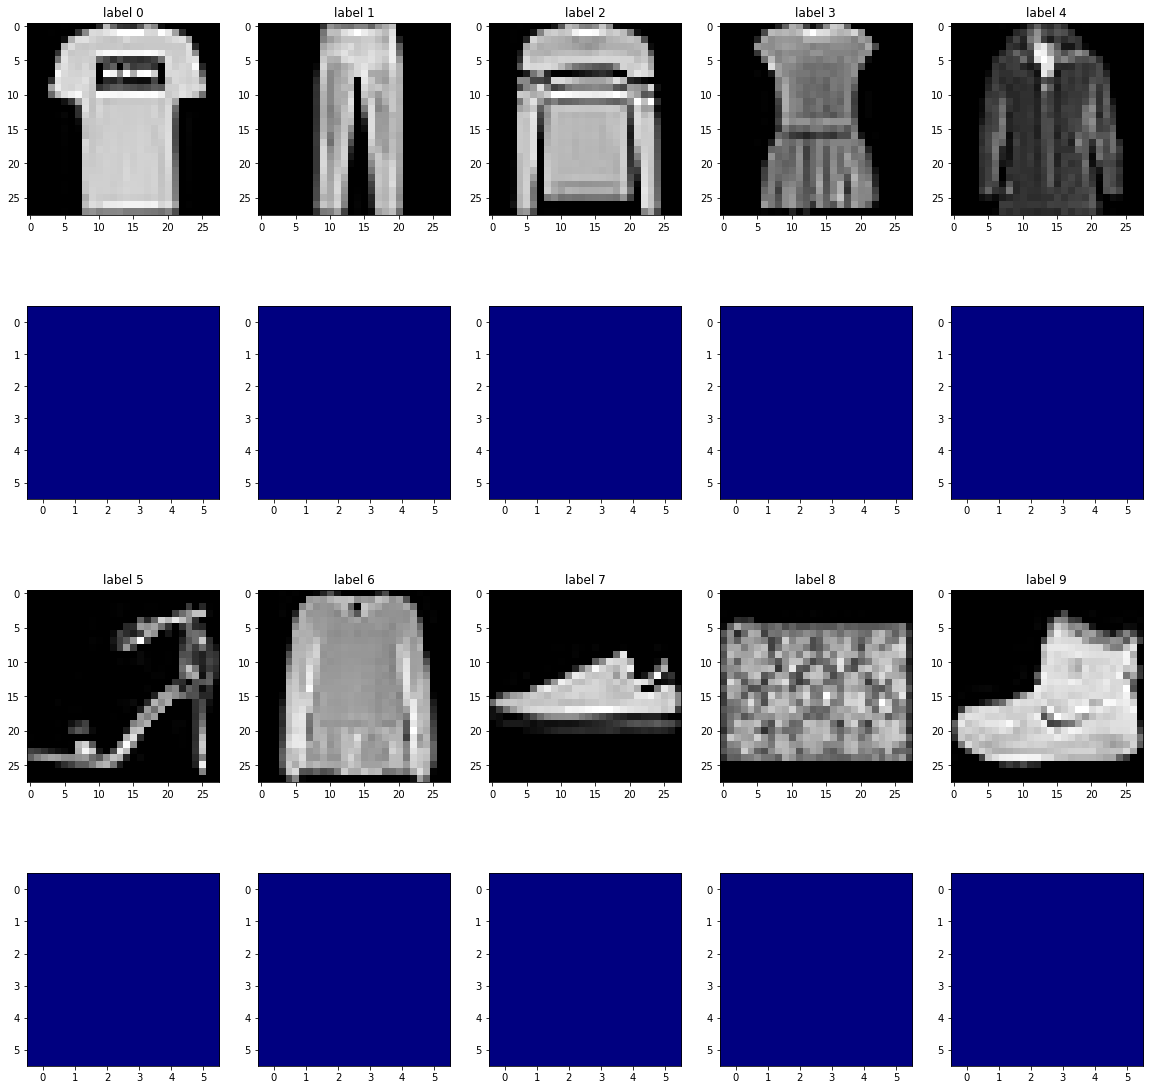


image  0
image shape (13, 13, 8, 1)
inactive ratio  0.4444444444444444
selected point 1 4 0

Updating the sample space
new filter initialized, id =  2
threshold_same_sum:  0.81
result 0 1.0
sum of matrix_1 =  8.940697e-08
char sum: 8.940697e-08

combined training v3
 95/100 [===========================>..] - ETA: 0s - loss: 19.7862inactive ratio after adding filter 0.4166666666666667


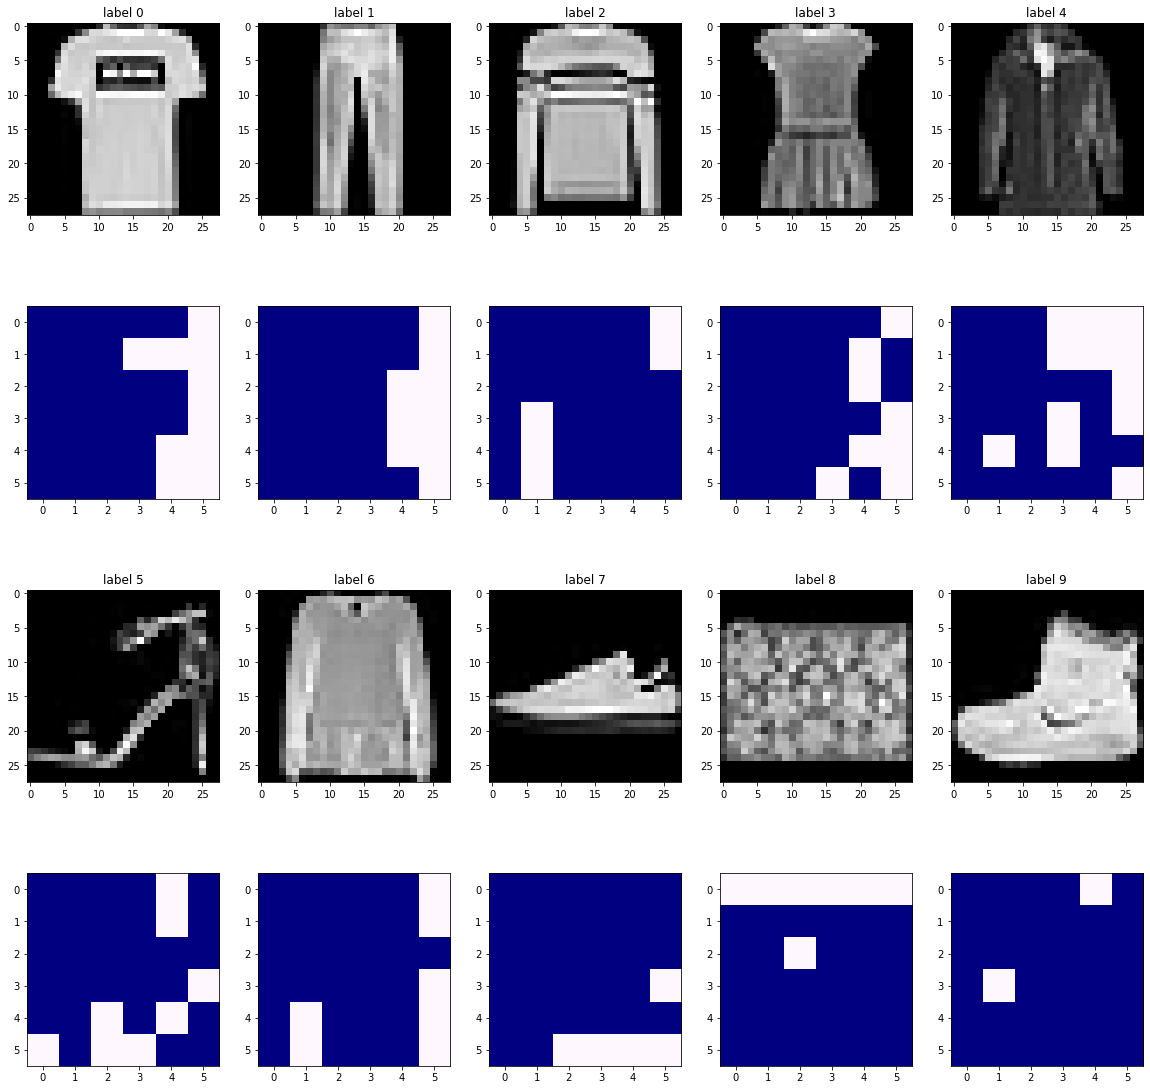


image  0
image shape (13, 13, 8, 1)
inactive ratio  0.4166666666666667
selected point 5 4 0

Updating the sample space
new filter initialized, id =  3
threshold_same_sum:  0.65
result 0 0.99999994
sum of matrix_1 =  -2.3841858e-07
char sum: -2.3841858e-07

combined training v3
 96/100 [===========================>..] - ETA: 0s - loss: 61.74 - ETA: 0s - loss: 62.4595inactive ratio after adding filter 0.3055555555555556


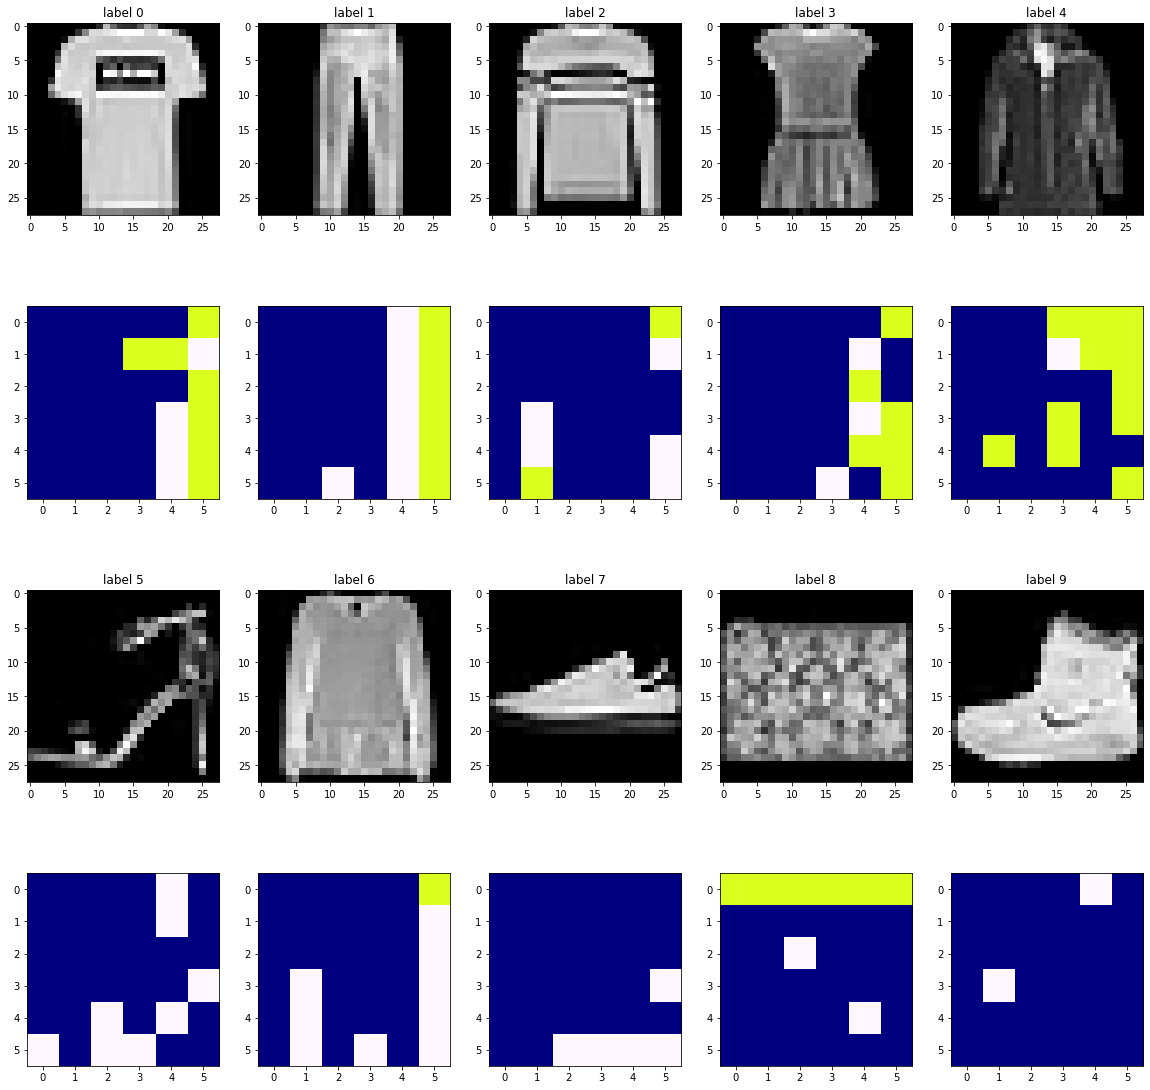

inactive ratios mean 0.3055555555555556 [0.3055555555555556]

image  0
image shape (13, 13, 8, 1)
inactive ratio  0.3055555555555556
selected point 3 0 0

Updating the sample space
new filter initialized, id =  4
threshold_same_sum:  0.5
result 0 1.0
sum of matrix_1 =  -2.9802322e-07
char sum: -2.9802322e-07

combined training v3
 99/100 [============================>.] - ETA: 0s - loss: 70.1122inactive ratio after adding filter 0.2222222222222222


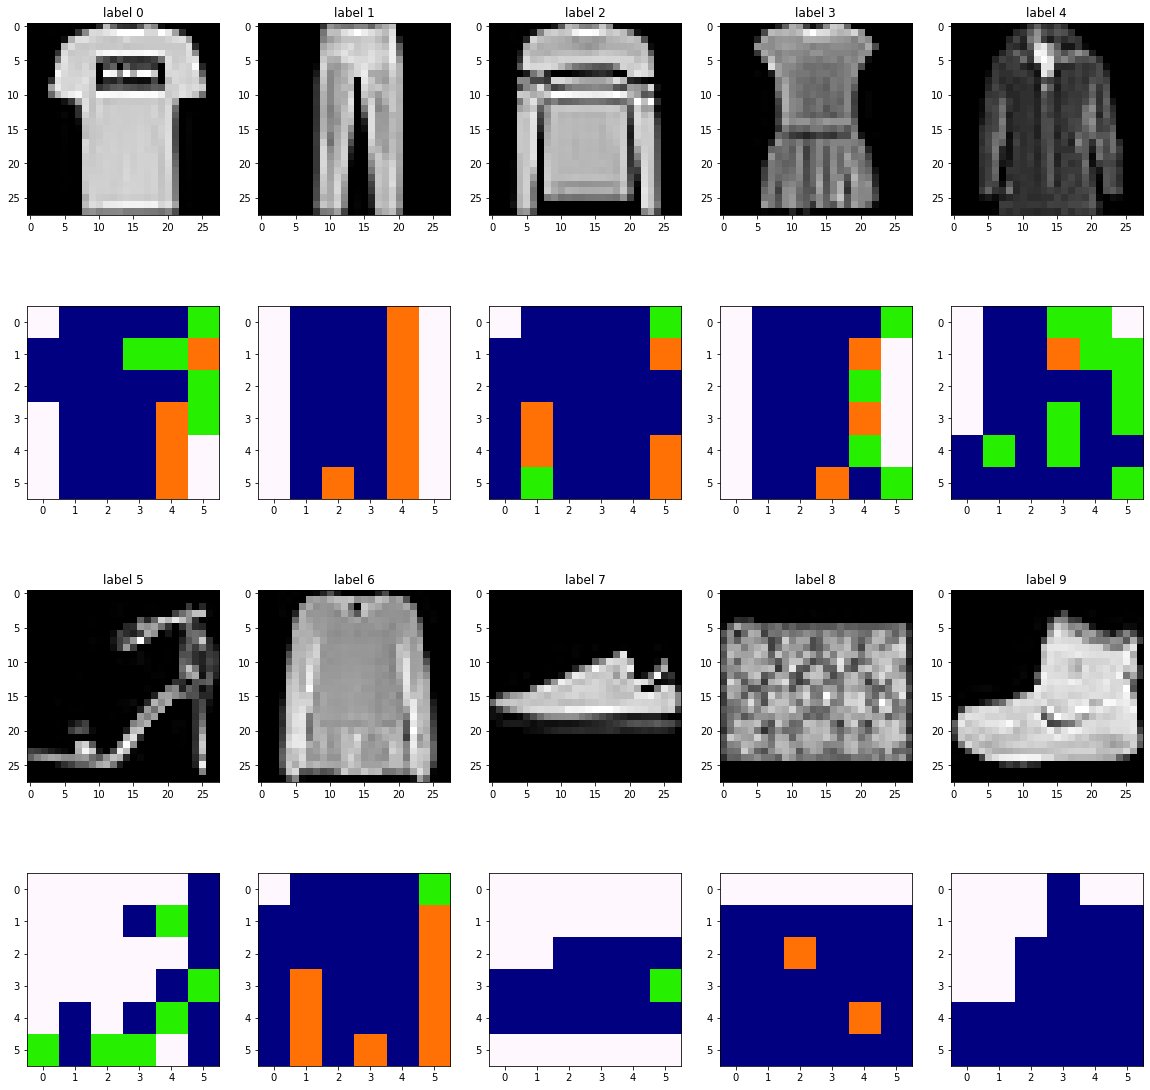

sigmoid 5
inactive ratios mean 0.2222222222222222 [0.2222222222222222]

image  0
image shape (13, 13, 8, 1)
inactive ratio  0.2222222222222222
selected point 0 0 0

Updating the sample space
new filter initialized, id =  5
threshold_same_sum:  0.59
result 0 1.0
sum of matrix_1 =  5.5134296e-07
char sum: 5.5134296e-07

combined training v3
 96/100 [===========================>..] - ETA: 0s - loss: 77.4275inactive ratio after adding filter 0.19444444444444445


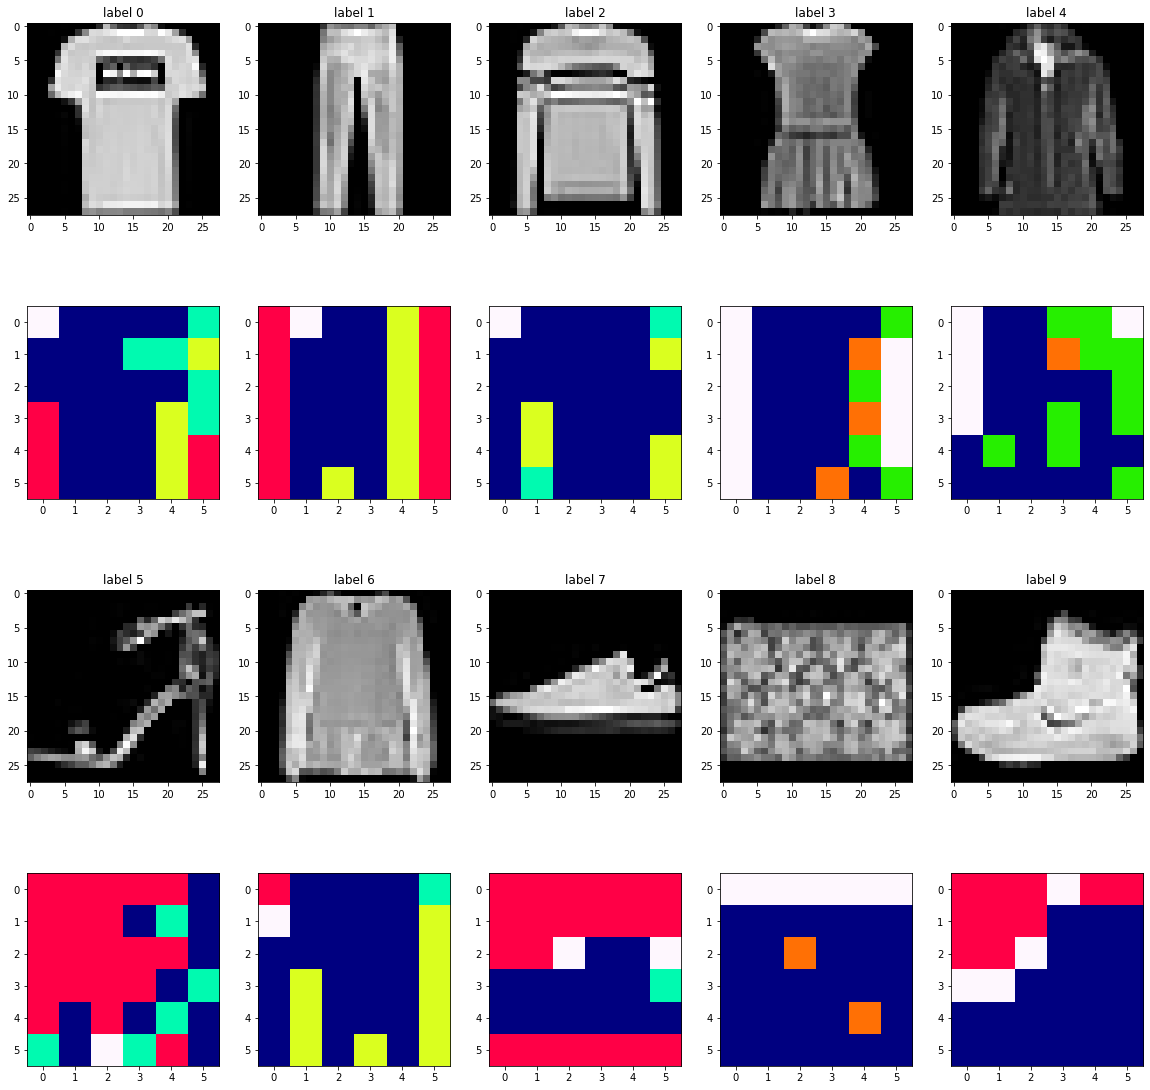

sigmoid 6
inactive ratios mean 0.19444444444444445 [0.19444444444444445]

image  0
image shape (13, 13, 8, 1)
inactive ratio  0.19444444444444445
selected point 5 5 0

Updating the sample space
new filter initialized, id =  6
threshold_same_sum:  0.6
result 0 1.0
sum of matrix_1 =  0.0
char sum: 0.0

combined training v3
 98/100 [============================>.] - ETA: 0s - loss: 161.6800Einactive ratio after adding filter 0.08333333333333333


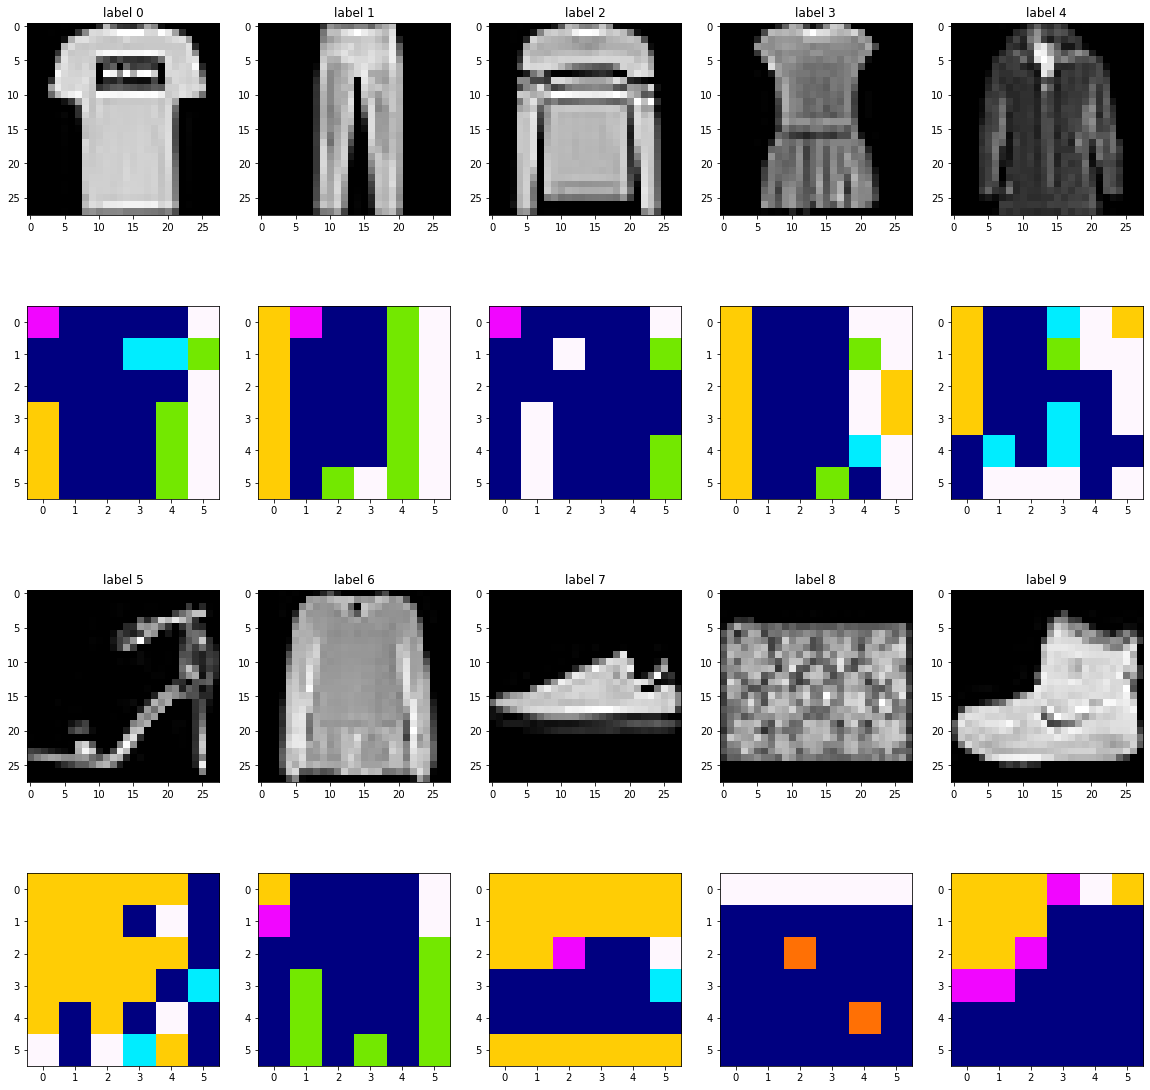

sigmoid 7
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.08333333333333333]
inactive ratios mean 0.08333333333333333 [0.0

In [44]:
for i in range(40):
    my_model_l2 = generate_model_on_images(fm_n, my_model_l2, fm_0_9)


In [45]:
#pring the filter weights in l2
filter_0 = my_model_l2.filter_list[1]
print(filter_0.get_weights()[0].reshape(filter_0.get_weights()[0].shape[:-2]), filter_0.get_weights()[1])

[[[-0.14183325 -0.53444654 -0.6340926   0.4027194   0.80426437
    1.2787197  -0.08529006 -0.9566519 ]
  [-1.9283662  -1.5846332   0.6399878  -1.9104564   1.0284575
    1.5397059  -1.7750833  -1.8925623 ]]

 [[-0.08527563  0.02375891 -1.775387   -0.68381596  0.3609318
   -0.35665792 -0.08527306  0.4945578 ]
  [-0.15891965 -1.2415129  -1.927384    1.7202796   1.4218137
    1.6229626  -0.08533439 -1.5431569 ]]] [-0.43767783]


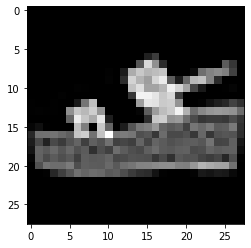

In [46]:

img_index = 12
fm_0_2 = my_model_l1.call(train_images[img_index].reshape(1, image_size, image_size, 1, 1)).numpy()#.reshape(fm_0.shape[1:])
#fm_0_2 = my_model_l1.call(images_x_0_9[9].reshape(1, image_size, image_size, 1, 1)).numpy()#.reshape(fm_0.shape[1:])
plt.imshow(train_images[img_index], cmap = "gray")

min max 0.00067019433 0.92479724


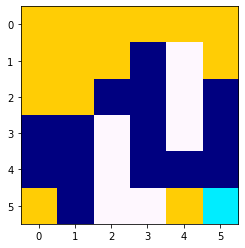

In [47]:
fm_l2 = my_model_l2.call(fm_0_2)
#print(fm_l2)
#print(fm_l2.numpy().reshape(fm_l2.shape[1:]))
index_map_fm_l2 = np.argmax(fm_l2.numpy().reshape(fm_l2.shape[1:]), axis = 2)
plt.imshow(index_map_fm_l2, cmap = "gist_ncar")
print("min max", np.min(fm_l2.numpy()[0,:,:,1,0]), np.max(fm_l2.numpy()[0,:,:,1,0]))

In [48]:
fm_l0_0_9 = []
for i in range(10):
    fm_l0_0_9.append(my_model_l1.call(images_x_0_9[i].reshape(1, image_size, image_size, 1, 1)).numpy())

fm_l2_0_9 = []
for i in range(10):
    fm_l2_0_9.append(my_model_l2.call(fm_l0_0_9[i]).numpy())
    
fm_l0_100 = []
n_count = 100

#1000 -- 30 seconds
#10000 -- 5 minutes
for i in range(n_count):
    fm_l0_100.append(my_model_l1.call(train_images[i].reshape(1, image_size, image_size, 1, 1)).numpy())

fm_l2_100 = []
for i in range(n_count):
    fm_l2_100.append(my_model_l2.call(fm_l0_100[i]).numpy())
    
y_100 = train_labels[:n_count]
#turn to one hot
y_100 = tf.one_hot(y_100, 10).numpy()


In [66]:
#train a basic model on the fm_l2_0_9
backend_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

backend_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

backend_model_l0 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
backend_model_l0.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [69]:

fm_l2_train = fm_l2_100
fm_l2_y = y_100

print(np.array(fm_l2_train).shape, np.array(fm_l2_y).reshape(len(fm_l2_y),10).shape)
backend_model.fit(np.array(fm_l2_train), np.array(fm_l2_y).reshape(len(fm_l2_y), 10), epochs=400, verbose = 0)
print("start training l0 classifier")
print(np.array(fm_l0_100).shape, np.array(fm_l2_y).reshape(len(fm_l2_y),10).shape)
backend_model_l0.fit(np.array(fm_l0_100), np.array(fm_l2_y).reshape(len(fm_l2_y), 10), epochs=400, verbose = 0)

(100, 1, 6, 6, 7, 1) (100, 10)
start training l0 classifier
(100, 1, 13, 13, 8, 1) (100, 10)


In [51]:

fm_test0 = my_model_l1.call(test_images[0].reshape(1, image_size, image_size, 1, 1)).numpy()
fm_test0_l2 = my_model_l2.call(fm_test0).numpy()


test_fms = []
test_fms_l1 = []
for i in tqdm.tqdm(range(len(test_images))):
    fm_l1_test = my_model_l1.call(test_images[i].reshape(1, image_size, image_size, 1, 1)).numpy()
    fm_l2_test = my_model_l2.call(fm_l1_test).numpy()
    test_fms.append(fm_l2_test)
    test_fms_l1.append(fm_l1_test)



  0%|          | 0/10000 [00:00<?, ?it/s]

10000 (1, 6, 6, 7, 1)
Testing l0 classifier


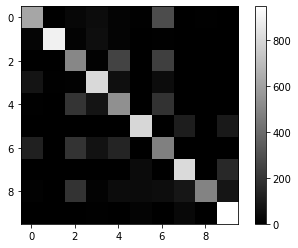

accuracy 0.6855
Testing l2 classifier


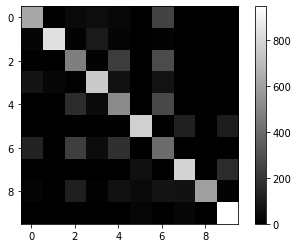

accuracy 0.6686


In [70]:
#experiment on backend model


print(len(test_fms), test_fms[0].shape)
print("Testing l0 classifier")
test_set = np.array(test_fms)
test_set = np.array(test_fms_l1) #for first layer test

prediction_test = backend_model_l0.predict(np.array(test_fms_l1)) #need to be adjusted according to the model

prediction_test = np.argmax(prediction_test, axis = 1)
conf_mat = [ [0 for i in range(10)] for j in range(10)]
for i in range(len(prediction_test)):
    conf_mat[int(test_labels[i])][int(prediction_test[i])] += 1

plt.imshow(conf_mat, cmap = "gray")
plt.colorbar()
plt.show()
print("accuracy", np.sum(np.diag(conf_mat))/np.sum(conf_mat))

print("Testing l2 classifier")
test_set = np.array(test_fms)

prediction_test = backend_model.predict(test_set) #need to be adjusted according to the model

prediction_test = np.argmax(prediction_test, axis = 1)
conf_mat = [ [0 for i in range(10)] for j in range(10)]
for i in range(len(prediction_test)):
    conf_mat[int(test_labels[i])][int(prediction_test[i])] += 1

plt.imshow(conf_mat, cmap = "gray")
plt.colorbar()
plt.show()
print("accuracy", np.sum(np.diag(conf_mat))/np.sum(conf_mat))

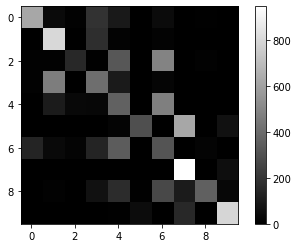

accuracy 0.5052


In [71]:
#one shot experiment
backend_one_shot = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax', use_bias=False)
])

fm_0_9 = []
y_0_9 = []
for i in range(10):
    fm_0_9.append(my_model_l1.call(images_x_0_9[i].reshape(1, image_size, image_size, 1, 1)).numpy())
    y_0_9.append([0 for j in range(10)])
    y_0_9[i][i] = 1

backend_one_shot.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

backend_one_shot.fit(np.array(fm_0_9), np.array(y_0_9).reshape(len(y_0_9), 10), epochs=400, verbose = 0)
prediction_test = backend_one_shot.predict(np.array(test_fms_l1)) #need to be adjusted according to the model
conf_mat = [ [0 for i in range(10)] for j in range(10)]

prediction_test = np.argmax(prediction_test, axis = 1)
for i in range(len(prediction_test)):
    conf_mat[int(test_labels[i])][int(prediction_test[i])] += 1
plt.imshow(conf_mat, cmap = "gray")
plt.colorbar()
plt.show()
print("accuracy", np.sum(np.diag(conf_mat))/np.sum(conf_mat))


In [ ]:
#one shot learning, with extra n unlabelled images taken from the training set
n_unlabelled = 1000

unlabelled_set = train_images[0:n_unlabelled]
actual_label = train_labels[0:n_unlabelled]

#get the fm l2 over unlabelled set

fm_l2 = []
fm_l1_list = []
for i in tqdm.tqdm(range(len(unlabelled_set))):
    fm_l1 = my_model_l1.call(unlabelled_set[i].reshape(1, image_size, image_size, 1, 1)).numpy()
    fm_l2.append(my_model_l2.call(fm_l1).numpy())
    fm_l1_list.append(fm_l1)


In [ ]:
#save the l1 and l2 models for later use
#taking out filters and biases
#parameters like activation function, kernel size, stride, padding, etc. are recorded
import os
def save_model(model, file_name):
    activation_func  = str(model.activation)
    kernel_size = str(model.kernel_size)
    stride = str(model.stride)
    padding = str(model.padding)
    
    filter_list = [None for i in range(len(model.filter_list))]
    bias_list = [None for i in range(len(model.filter_list))]
    for i in range(len(model.filter_list)):
        weight_filter_i = model.filter_list[i].get_weights()
        filter_list[i] = weight_filter_i[0]
        bias_list[i] = weight_filter_i[1]
    
    
    #make a dictionary to store the parameters
    model_dict = {
        "activation_func": activation_func,
        "kernel_size": kernel_size,
        "stride": stride,
        "padding": padding,
        "filter_list": filter_list,
        "bias_list": bias_list
    }
    #save the dictionary
    import pickle
    with open(file_name, 'wb') as handle:
        pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    

#check if "models" folder exists, if not, create one

if not os.path.exists("models"):
    os.makedirs("models")

#make a directory for the model
import time
current_time = time.localtime()
current_time_str = str(current_time.tm_year) + "_" + str(current_time.tm_mon) + "_" + str(current_time.tm_mday) + "_" + str(current_time.tm_hour) + "_" + str(current_time.tm_min) + "_" + str(current_time.tm_sec)
model_name = "model_" + current_time_str
os.makedirs("models/" + model_name)


save_model(my_model_l1, "models/"+model_name + "/l1_model.txt")
save_model(my_model_l2,"models/" +model_name + "/l2_model.txt")
    


In [ ]:
#read the model back
def read_model(file_name):
    import pickle
    with open(file_name, 'rb') as handle:
        model_dict = pickle.load(handle)
    return model_dict

test_01_dict = read_model("models/"+model_name + "/l1_model.txt")
print(test_01_dict["activation_func"])

In [ ]:
#give the images 5-9 to the layer 1 model

images_x_5_9 = images_x_0_9[0:10]

my_model_l1 = generate_model_on_images(images_x_5_9, model=my_model_l1, images_0_9=images_x_0_9, inactive_ratio_threshold=inactive_ratio_threshold)


In [ ]:

fm_l1_5_9 = []

for i in range(len(images_x_5_9)):
    fm_l1_5_9.append(my_model_l1.call(images_x_5_9[i].reshape(1, image_size, image_size, 1, 1)).numpy())

fm_l1_0_9 = []
for i in range(len(images_x_0_9)):
    fm_l1_0_9.append(my_model_l1.call(images_x_0_9[i].reshape(1, image_size, image_size, 1, 1)).numpy())
#send to layer 2 model
for epoch in range(5):
    my_model_l2 = generate_model_on_images(fm_l1_5_9, model=my_model_l2, images_0_9=fm_l1_0_9, inactive_ratio_threshold=inactive_ratio_threshold)

In [ ]:
#make the transfer learning sub models